# Import Modules

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from tensorflow.keras.layers import Input, Add, Activation, Lambda, Embedding, Reshape, Dot

# Data Understanding

## Import and Load Dataset

In [ ]:
# !pip install -q kaggle
# !mkdir ~/.kaggle/
# !cp /notebooks/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d "hernan4444/anime-recommendation-database-2020"
# !unzip anime-recommendation-database-2020.zip

## Dataset Description

Dataset ini berisi informasi _anime_ sebanyak 17.562 dan pengguna sebesar 325.772 dimana informasi yang disimpan sebagai berikut.

* Daftar _anime_ per pengguna, termasuk _anime_ yang status _dropped_, ditamatin, direncakan untuk di tonton, sedang di tonton atau _on hold_
* Rating yang diberikan oleh pengguna terhadap _anime_ yang sudah tamat di tonton, sedang di tonton ataupun _on hold_
* Informasi mengenai _anime_ seperti _genre, stats, studio_, dan sebagainya
* _HTML file_ dengan informasi _anime_ hasil _scrapping_

Untuk file _csv_, terdapat 5 file _csv_, yaitu
1. `anime.csv`
2. `anime_with_synopsis.csv`
3. `animelist.csv`
4. `rating_complete.csv`
5. `watching_status.csv`

In [ ]:
anime_df = pd.read_csv('anime.csv')
anime_sypnopsis_df = pd.read_csv('anime_with_synopsis.csv')
anime_list_df = pd.read_csv('animelist.csv')
rating_complete_df = pd.read_csv('rating_complete.csv')
watching_status_df = pd.read_csv('watching_status.csv')

print('Jumlah Seluruh Data Anime :', len(anime_df.MAL_ID.unique()))
print('Jumlah Data Anime dengan Sinopsis :', len(anime_sypnopsis_df.MAL_ID.unique()))
print('Jumlah Data Anime yang Ditambah User :', len(anime_list_df.anime_id.unique()))
print('Jumlah Data Anime yang Dirating User Setelah Tamat :',
      len(rating_complete_df.anime_id.unique()))

Jumlah Seluruh Data Anime : 17562
Jumlah Data Anime dengan Sinopsis : 16214
Jumlah Data Anime yang Ditambah User : 17562
Jumlah Data Anime yang Dirating User Setelah Tamat : 16872


# Univariate Exploratory Data Analysis

Variabel-variabel pada dataset ini adalah

* **anime_df** - Berisi informasi _anime_ secara general seperti _genre, stats, studio_, dan sebagainya
* **anime_sypnopsis_df** - Berisi informasi _anime_ yang lebih ringkas dibandingkan dengan **anime_df** namun ditambah dengan sinopsis setiap _anime_
* **anime_list_df** - Berisi daftar _anime_ yang didaftarkan oleh pengguna dengan skor _rating_, status _watching_ dan jumlah episode yang sudah ditonton
* **rating_complete_df** - Berisi daftar _rating_ setiap _anime_ dengan _watching status_ adalah **2** yang berarti tamat ditonton
* **watching_status_df** - Berisi daftar kode status _watching_ untuk kolom "watching_list" di variabel **anime_list_df**

In [ ]:
raw_anime_mask = ['Name', 'Score', 'Genres', 'Type', 'Episodes', 'Aired', 'Premiered']

## Anime

In [ ]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

Berdasarkan variabel dari _file anime_, terdapat 17562 data dan terdapat 35 kolom dimana variabel dimana penjelasan kolomnya adalah sebagai berikut

* **MAL_ID** : ID _anime_ yang dicatat di _MyAnimeList_
* **Name** : Judul lengkap _anime_
* **Score** : _Rating_ rata-rata dari seluruh pengguna yang telah menilai _anime_ tersebut
* **Genres** : Kumpulan _genre_ dari sebuah _anime_
* **English name** : Judul _anime_ dalam Bahasa Inggris
* **Japanese name** : Judul _anime_ dalam aksara Jepang
* **Type** : Tipe/format penayangan _anime_, seperti **TV, Movie, OVA**
* **Episodes** : Jumlah episode
* **Aired** : Tanggal rilis/penayangan perdana
* **Premiered** : Musim penayangan perdana
* **Producers** : Produser yang menaungin produksi _anime_
* **Studios** : Studio utama _anime_ tersebut diproduksi
* **Source** : Sumber material dari _anime_, seperti _Manga, Visual Novel, Light Novel_ atau _Original_
* **Duration** : Durasi _anime_ dalam sekali tayang per episode
* **Rating** : _Rating_ usia penonton
* **Ranked** : Posisi ranking berdasarkan skor _rating_ rata-rata
* **Popularity** : Posisi popularitas berdasarkan jumlah pengguna yang menambahkan _anime_ tersebut di dalam daftar _anime_-nya
* **Members** : Jumlah pengguna yang menambahkan _anime_ tersebut di daftar _anime_ pada akun mereka
* **Favorites** : Jumlah pengguna yang memfavoritkan _anime_ tersebut
* **Watching** : Jumlah pengguna yang menonton _anime_ tersebut
* **Completed** : Jumlah pengguna yang menamatkan _anime_ tersebut
* **On-Hold** : Jumlah pengguna yang berhenti sementara menonton _anime_ tersebut
* **Dropped** : Jumlah pengguna yang tidak melanjutkan menonton _anime_ tersebut
* **Plan to Watch** : Jumlah pengguna yang berencana menonton _anime_ tersebut
* **Score-10** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 10
* **Score-9** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 9
* **Score-8** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 8
* **Score-7** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 7
* **Score-6** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 6
* **Score-5** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 5
* **Score-4** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 4
* **Score-3** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 3
* **Score-2** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 2
* **Score-1** : Jumlah pengguna yang memberikan skor / _rating_ dengan nilai 1

## Anime With Sypnopsis

In [ ]:
anime_sypnopsis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genres     16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


Berdasarkan dari variabel berikut, terdapat 16214 data dan terdapat 5 kolom dimana variabel dimana penjelasan kolomnya adalah sebagai berikut

* **MAL_ID** : ID _anime_ yang dicatat di _MyAnimeList_
* **Name** : Judul lengkap _anime_
* **Score** : _Rating_ rata-rata dari seluruh pengguna yang telah menilai _anime_ tersebut
* **Genres** : Kumpulan _genre_ dari sebuah _anime_
* **synopsis** : Sinopsis dari _anime_

## Anime List

In [ ]:
anime_list_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109224216 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           int64 
 1   anime_id          int64 
 2   rating            int64 
 3   watching_status   object
 4   watched_episodes  int64 
dtypes: int64(4), object(1)
memory usage: 4.9+ GB


Berdasarkan dari variabel berikut, jika melihat dari _RangeIndex_ terdapat 109.224.747 data dan terdapat 5 kolom dimana variabel dimana penjelasan kolomnya adalah sebagai berikut

* **user_id** : ID pengguna secara _random_ dan tidak terkait dengan id pengguna di _MyAnimeList_
* **anime_id** : ID _anime_ di _MyAnimeList_
* **score** : Skor atau _rating_ yang diberi pengguna terhadap _anime_ tersebut. Skor 0 menunjukkan pengguna tidak memberikan skor/_rating_
* **watching_status** : ID Status nonton dari pengguna berdasarkan variabel **watching_status_df**
* **watched_episodes** : Jumlah episode yang sudah ditonton pengguna

## Watching Status

In [ ]:
watching_status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        5 non-null      int64 
 1    description  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


Berdasarkan dari variabel berikut, terdapat 5 data dan terdapat 2 kolom dimana variabel dimana penjelasan kolomnya adalah sebagai berikut

* **status** : ID status nonton dari pengguna untuk kolom "watching_status" di variabel **anime_list_df**
* **description** : Deskripsi dari ID status

Variabel ini dipakai sebagai _indexing_ atau penanda untuk kolom "watching_status" di variabel **anime_list_df**

## Rating Complete

In [ ]:
rating_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


Berdasarkan dari variabel berikut, terdapat 57.633.278 data dan terdapat 3 kolom dimana variabel dimana penjelasan kolomnya adalah sebagai berikut

* **user_id** : ID pengguna secara _random_ dan tidak terkait dengan id pengguna di _MyAnimeList_
* **anime_id** : ID _anime_ di _MyAnimeList_
* **rating** : _rating_ atau skor yang diberikan pengguna

## Top 20 Anime Berdasarkan Popularitas

In [ ]:
top_20_popular = anime_df[anime_df['Popularity'] > 0].sort_values(by='Popularity', ascending=True).head(20)
top_20_popular[raw_anime_mask]

,Name,Score,Genres,Type,Episodes,Aired,Premiered
1393,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",TV,37,"Oct 4, 2006 to Jun 27, 2007",Fall 2006
7449,Shingeki no Kyojin,8.48,"Action, Military, Mystery, Super Power, Drama,...",TV,25,"Apr 7, 2013 to Sep 29, 2013",Spring 2013
3971,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009
6614,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",TV,25,"Jul 8, 2012 to Dec 23, 2012",Summer 2012
10451,One Punch Man,8.57,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",TV,12,"Oct 5, 2015 to Dec 21, 2015",Fall 2015
11185,Boku no Hero Academia,8.11,"Action, Comedy, School, Shounen, Super Power",TV,13,"Apr 3, 2016 to Jun 26, 2016",Spring 2016
8646,Tokyo Ghoul,7.81,"Action, Mystery, Horror, Psychological, Supern...",TV,12,"Jul 4, 2014 to Sep 19, 2014",Summer 2014
10,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",TV,220,"Oct 3, 2002 to Feb 8, 2007",Fall 2002
5683,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011
8148,No Game No Life,8.2,"Game, Adventure, Comedy, Supernatural, Ecchi, ...",TV,12,"Apr 9, 2014 to Jun 25, 2014",Spring 2014


In [ ]:
top_20_popular.describe()

,MAL_ID,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,20.000000,20.000000,2.000000e+01,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000
mean,14818.200000,10.450000,1.841283e+06,76094.800000,111893.700000,1.455585e+06,42417.850000,43904.050000,187482.650000
std,11497.723819,5.799047,3.307234e+05,48984.685432,73851.028262,3.555334e+05,26652.020913,31588.052956,86484.320615
min,20.000000,1.000000,1.533289e+06,18262.000000,40773.000000,8.656430e+05,4746.000000,2463.000000,69610.000000
25%,4891.500000,5.750000,1.589600e+06,45872.250000,69177.500000,1.189135e+06,25307.500000,26080.250000,125984.750000
50%,11409.000000,10.500000,1.738857e+06,60010.500000,85603.000000,1.408098e+06,35789.000000,36710.000000,178442.000000
75%,23183.500000,15.250000,1.963327e+06,100326.250000,126092.500000,1.647678e+06,61128.000000,47310.500000,233306.500000
max,33486.000000,19.000000,2.589552e+06,183914.000000,362124.000000,2.182587e+06,109707.000000,124253.000000,425531.000000


In [ ]:
print(top_20_popular[raw_anime_mask+['Popularity']].to_markdown())

|       | Name                             |   Score | Genres                                                              | Type   |   Episodes | Aired                        | Premiered   |   Popularity |
|------:|:---------------------------------|--------:|:--------------------------------------------------------------------|:-------|-----------:|:-----------------------------|:------------|-------------:|
|  1393 | Death Note                       |    8.63 | Mystery, Police, Psychological, Supernatural, Thriller, Shounen     | TV     |         37 | Oct 4, 2006 to Jun 27, 2007  | Fall 2006   |            1 |
|  7449 | Shingeki no Kyojin               |    8.48 | Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen     | TV     |         25 | Apr 7, 2013 to Sep 29, 2013  | Spring 2013 |            2 |
|  3971 | Fullmetal Alchemist: Brotherhood |    9.19 | Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen | TV     |         64 | Apr 5, 2009 to Jul 4, 201

## Top 20 Anime yang Paling Banyak Ditamatin

<AxesSubplot: title={'center': 'Top 20 Anime Paling Banyak Ditamatin'}, xlabel='Name'>

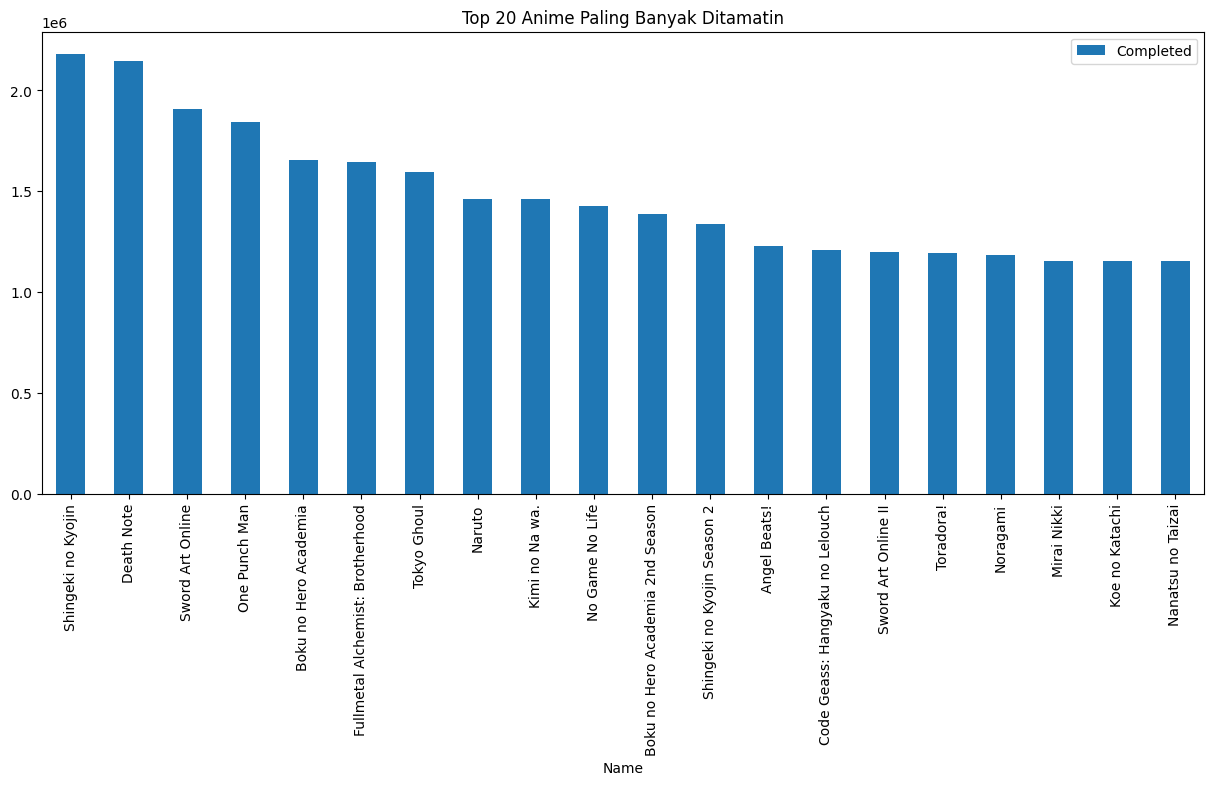

In [ ]:
anime_df.sort_values(by='Completed', ascending=False).head(20).plot(
    x='Name', y='Completed', kind='bar', figsize=(15,6), title='Top 20 Anime Paling Banyak Ditamatin')

In [ ]:
anime_df[raw_anime_mask+['Completed']].sort_values(by='Completed', ascending=False).head(20)

,Name,Score,Genres,Type,Episodes,Aired,Premiered,Completed
7449,Shingeki no Kyojin,8.48,"Action, Military, Mystery, Super Power, Drama,...",TV,25,"Apr 7, 2013 to Sep 29, 2013",Spring 2013,2182587
1393,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",TV,37,"Oct 4, 2006 to Jun 27, 2007",Fall 2006,2146116
6614,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",TV,25,"Jul 8, 2012 to Dec 23, 2012",Summer 2012,1907261
10451,One Punch Man,8.57,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",TV,12,"Oct 5, 2015 to Dec 21, 2015",Fall 2015,1841220
11185,Boku no Hero Academia,8.11,"Action, Comedy, School, Shounen, Super Power",TV,13,"Apr 3, 2016 to Jun 26, 2016",Spring 2016,1655900
3971,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,1644938
8646,Tokyo Ghoul,7.81,"Action, Mystery, Horror, Psychological, Supern...",TV,12,"Jul 4, 2014 to Sep 19, 2014",Summer 2014,1594880
10,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",TV,220,"Oct 3, 2002 to Feb 8, 2007",Fall 2002,1462223
11308,Kimi no Na wa.,8.96,"Romance, Supernatural, School, Drama",Movie,1,"Aug 26, 2016",Unknown,1462143
8148,No Game No Life,8.2,"Game, Adventure, Comedy, Supernatural, Ecchi, ...",TV,12,"Apr 9, 2014 to Jun 25, 2014",Spring 2014,1426896


In [ ]:
anime_df[raw_anime_mask+['Completed']].sort_values(by='Completed', ascending=False).head(20).describe()

,Completed
count,2.000000e+01
mean,1.475986e+06
std,3.294567e+05
min,1.151443e+06
25%,1.197812e+06
50%,1.408098e+06
75%,1.647678e+06
max,2.182587e+06


In [ ]:
print(anime_df[raw_anime_mask+['Completed']].sort_values(by='Completed', ascending=False).head(20).to_markdown())

|       | Name                             |   Score | Genres                                                              | Type   |   Episodes | Aired                       | Premiered   |   Completed |
|------:|:---------------------------------|--------:|:--------------------------------------------------------------------|:-------|-----------:|:----------------------------|:------------|------------:|
|  7449 | Shingeki no Kyojin               |    8.48 | Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen     | TV     |         25 | Apr 7, 2013 to Sep 29, 2013 | Spring 2013 |     2182587 |
|  1393 | Death Note                       |    8.63 | Mystery, Police, Psychological, Supernatural, Thriller, Shounen     | TV     |         37 | Oct 4, 2006 to Jun 27, 2007 | Fall 2006   |     2146116 |
|  6614 | Sword Art Online                 |    7.25 | Action, Game, Adventure, Romance, Fantasy                           | TV     |         25 | Jul 8, 2012 to Dec 23, 2012 | Sum

## Top 20 Anime yang Paling Banyak Di-Drop

<AxesSubplot: title={'center': 'Top 20 Anime Paling Banyak Di-Drop'}, xlabel='Name'>

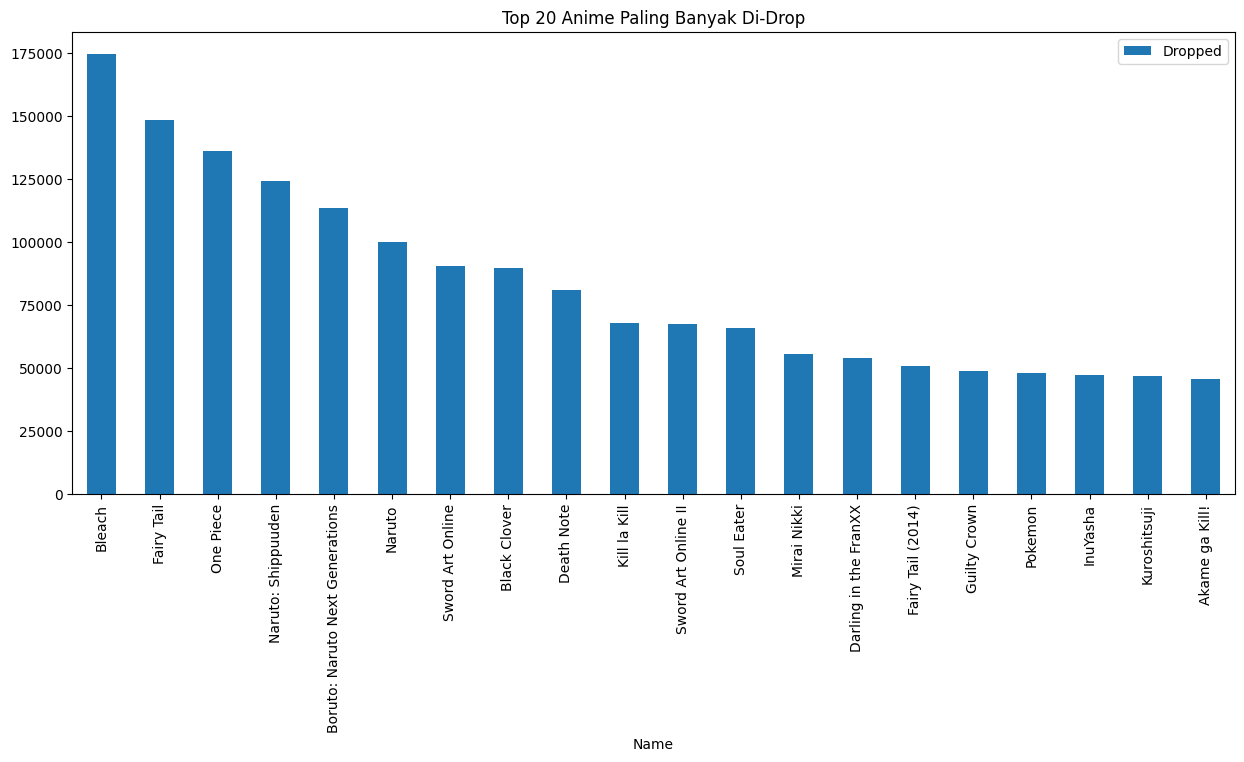

In [ ]:
anime_df.sort_values(by='Dropped', ascending=False).head(20).plot(
    x='Name', y='Dropped', kind='bar', figsize=(15,6), title='Top 20 Anime Paling Banyak Di-Drop')

In [ ]:
anime_df[raw_anime_mask+['Dropped']].sort_values(by='Dropped', ascending=False).head(20)

,Name,Score,Genres,Type,Episodes,Aired,Premiered,Dropped
245,Bleach,7.8,"Action, Adventure, Comedy, Super Power, Supern...",TV,366,"Oct 5, 2004 to Mar 27, 2012",Fall 2004,174710
4707,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",TV,175,"Oct 12, 2009 to Mar 30, 2013",Fall 2009,148408
11,One Piece,8.52,"Action, Adventure, Comedy, Super Power, Drama,...",TV,Unknown,"Oct 20, 1999 to ?",Fall 1999,136245
1574,Naruto: Shippuuden,8.16,"Action, Adventure, Comedy, Super Power, Martia...",TV,500,"Feb 15, 2007 to Mar 23, 2017",Winter 2007,124253
12492,Boruto: Naruto Next Generations,5.81,"Action, Adventure, Super Power, Martial Arts, ...",TV,Unknown,"Apr 5, 2017 to ?",Spring 2017,113677
10,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",TV,220,"Oct 3, 2002 to Feb 8, 2007",Fall 2002,99806
6614,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",TV,25,"Jul 8, 2012 to Dec 23, 2012",Summer 2012,90661
12493,Black Clover,7.38,"Action, Comedy, Magic, Fantasy, Shounen",TV,170,"Oct 3, 2017 to Mar 30, 2021",Fall 2017,89594
1393,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",TV,37,"Oct 4, 2006 to Jun 27, 2007",Fall 2006,80834
7939,Kill la Kill,8.11,"Action, Comedy, Super Power, Ecchi, School",TV,24,"Oct 4, 2013 to Mar 28, 2014",Fall 2013,67845


In [ ]:
anime_df[raw_anime_mask+['Dropped']].sort_values(by='Dropped', ascending=False).head(20).describe()

,Dropped
count,20.000000
mean,82774.300000
std,38640.959825
min,45684.000000
25%,50185.750000
50%,67544.000000
75%,103273.750000
max,174710.000000


In [ ]:
print(anime_df[raw_anime_mask+['Dropped']].sort_values(by='Dropped', ascending=False).head(20).to_markdown())

|       | Name                            |   Score | Genres                                                                                        | Type   | Episodes   | Aired                        | Premiered   |   Dropped |
|------:|:--------------------------------|--------:|:----------------------------------------------------------------------------------------------|:-------|:-----------|:-----------------------------|:------------|----------:|
|   245 | Bleach                          |    7.8  | Action, Adventure, Comedy, Super Power, Supernatural, Shounen                                 | TV     | 366        | Oct 5, 2004 to Mar 27, 2012  | Fall 2004   |    174710 |
|  4707 | Fairy Tail                      |    7.68 | Action, Adventure, Comedy, Magic, Fantasy, Shounen                                            | TV     | 175        | Oct 12, 2009 to Mar 30, 2013 | Fall 2009   |    148408 |
|    11 | One Piece                       |    8.52 | Action, Adventure, Comedy, Sup

## Distribusi Anime Berdasarkan Musim Penayangan

<AxesSubplot: title={'center': 'Distribusi Anime berdasarkan Musim Penayangan'}, ylabel='season'>

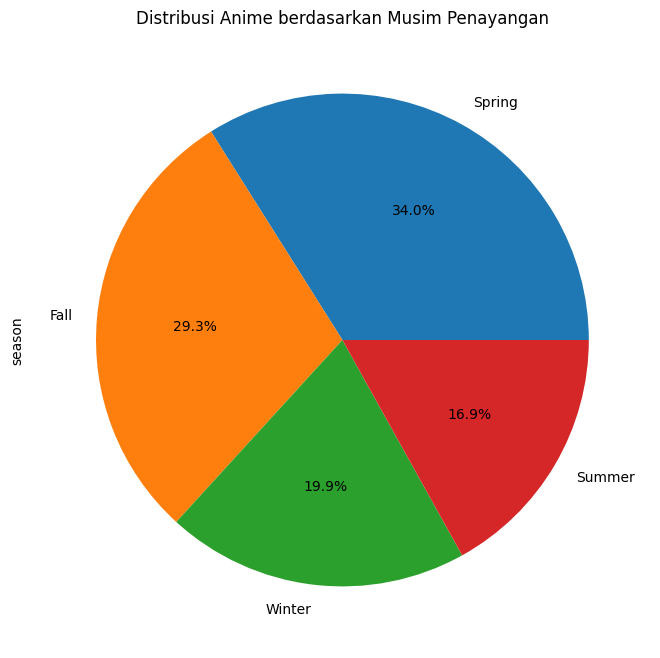

In [ ]:
anime_df['season'] = anime_df.loc[anime_df['Premiered'] != 'Unknown', 'Premiered'].str.split().str[0]
anime_df['season'].value_counts().plot(
    kind='pie', figsize=(8, 8), autopct='%1.1f%%', title='Distribusi Anime berdasarkan Musim Penayangan')

In [ ]:
print(anime_df['season'].value_counts())

Spring    1611
Fall      1389
Winter     942
Summer     803
Name: season, dtype: int64


## Top 20 Anime yang Paling Banyak Ditambahkan Ke Daftar Anime

<AxesSubplot: title={'center': 'Top 20 Anime Paling Banyak Ditambahkan Ke Daftar Anime'}, xlabel='Title'>

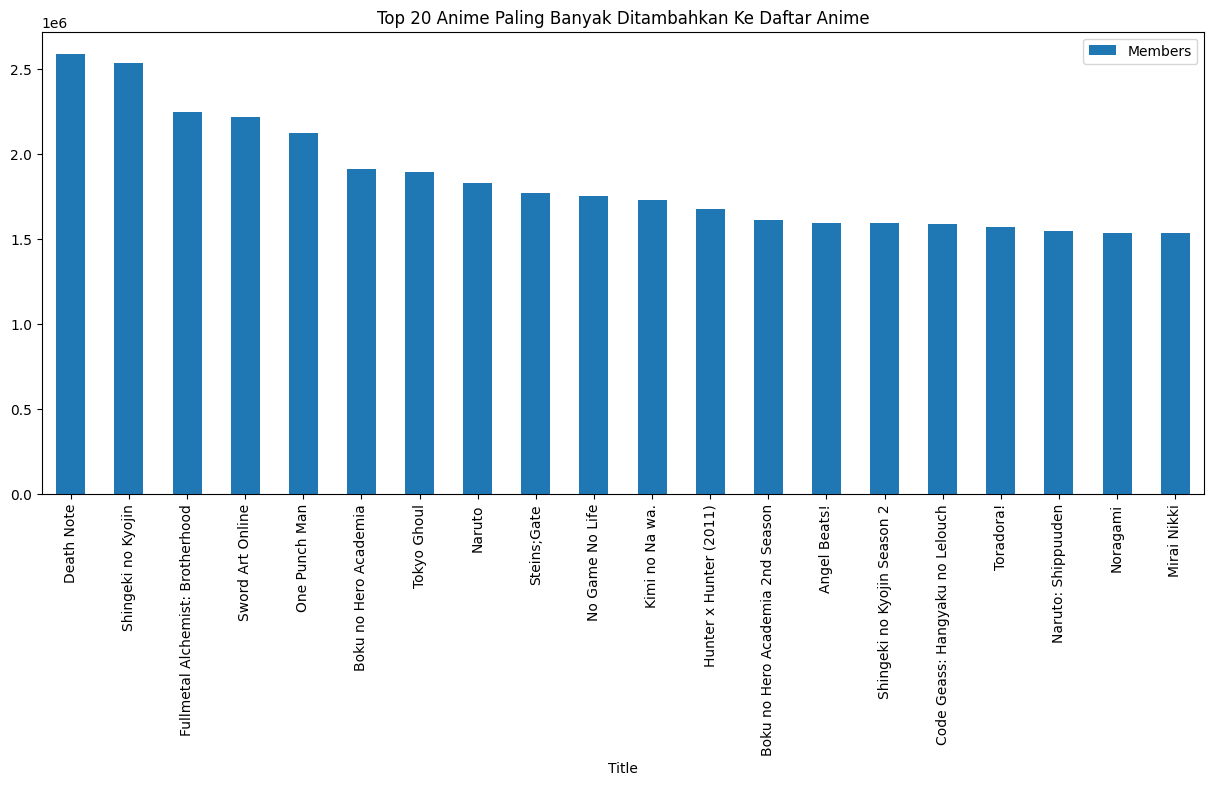

In [ ]:
anime_df.sort_values(by='Members', ascending=False).head(20).plot(
    x='Name', y='Members', xlabel='Title', kind='bar', figsize=(15,6), title='Top 20 Anime Paling Banyak Ditambahkan Ke Daftar Anime')

In [ ]:
anime_df[raw_anime_mask+['Members']].sort_values(by='Members', ascending=False).head(20)

,Name,Score,Genres,Type,Episodes,Aired,Premiered,Members
1393,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",TV,37,"Oct 4, 2006 to Jun 27, 2007",Fall 2006,2589552
7449,Shingeki no Kyojin,8.48,"Action, Military, Mystery, Super Power, Drama,...",TV,25,"Apr 7, 2013 to Sep 29, 2013",Spring 2013,2531397
3971,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,2248456
6614,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",TV,25,"Jul 8, 2012 to Dec 23, 2012",Summer 2012,2214395
10451,One Punch Man,8.57,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",TV,12,"Oct 5, 2015 to Dec 21, 2015",Fall 2015,2123866
11185,Boku no Hero Academia,8.11,"Action, Comedy, School, Shounen, Super Power",TV,13,"Apr 3, 2016 to Jun 26, 2016",Spring 2016,1909814
8646,Tokyo Ghoul,7.81,"Action, Mystery, Horror, Psychological, Supern...",TV,12,"Jul 4, 2014 to Sep 19, 2014",Summer 2014,1895488
10,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",TV,220,"Oct 3, 2002 to Feb 8, 2007",Fall 2002,1830540
5683,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,1771162
8148,No Game No Life,8.2,"Game, Adventure, Comedy, Supernatural, Ecchi, ...",TV,12,"Apr 9, 2014 to Jun 25, 2014",Spring 2014,1751054


In [ ]:
print(anime_df[raw_anime_mask+['Members']].sort_values(by='Members', ascending=False).head(20).to_markdown())

|       | Name                             |   Score | Genres                                                              | Type   |   Episodes | Aired                        | Premiered   |   Members |
|------:|:---------------------------------|--------:|:--------------------------------------------------------------------|:-------|-----------:|:-----------------------------|:------------|----------:|
|  1393 | Death Note                       |    8.63 | Mystery, Police, Psychological, Supernatural, Thriller, Shounen     | TV     |         37 | Oct 4, 2006 to Jun 27, 2007  | Fall 2006   |   2589552 |
|  7449 | Shingeki no Kyojin               |    8.48 | Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen     | TV     |         25 | Apr 7, 2013 to Sep 29, 2013  | Spring 2013 |   2531397 |
|  3971 | Fullmetal Alchemist: Brotherhood |    9.19 | Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen | TV     |         64 | Apr 5, 2009 to Jul 4, 2010   | Spring

## Score Feature

In [ ]:
anime_df['Score'].unique()

array([8.78, 8.39, 8.24, 7.27, 6.98, 7.95, 8.06, 7.59, 8.15, 8.76, 7.91,
       8.52, 7.9 , 6.38, 7.94, 7.42, 7.76, 7.32, 7.51, 8.32, 7.45, 8.51,
       8.49, 8.29, 8.73, 8.31, 7.56, 8.17, 7.35, 6.31, 7.26, 7.14, 7.1 ,
       6.53, 5.91, 7.05, 7.43, 7.66, 7.2 , 6.77, 6.62, 7.44, 7.65, 7.98,
       7.58, 7.38, 6.35, 8.07, 7.96, 7.3 , 7.99, 7.09, 7.78, 8.03, 6.79,
       7.92, 6.66, 7.68, 6.67, 6.76, 7.72, 7.79, 7.22, 7.7 , 7.82, 7.46,
       7.31, 7.48, 7.39, 7.23, 6.46, 7.29, 6.81, 7.63, 6.83, 4.95, 7.93,
       6.97, 6.85, 6.56, 7.69, 7.64, 6.86, 6.49, 6.91, 6.96, 7.41, 7.61,
       6.21, 8.11, 8.42, 8.33, 8.21, 6.14, 6.87, 7.11, 7.24, 7.12, 7.28,
       6.59, 7.34, 6.34, 7.33, 6.94, 6.48, 8.72, 8.53, 6.93, 6.63, 6.19,
       7.55, 7.18, 6.69, 7.21, 6.37, 8.12, 7.89, 6.11, 7.25, 6.8 , 7.17,
       6.88, 6.55, 8.83, 6.75, 8.5 , 7.16, 7.4 , 7.67, 6.26, 6.02, 6.15,
       5.94, 6.28, 7.52, 5.76, 6.65, 6.68, 8.  , 6.92, 7.02, 6.18, 8.16,
       6.64, 8.09, 7.36, 6.45, 8.7 , 7.85, 7.07, 7.

In [ ]:
## Ganti Score dengan nilai "Unknown" dengan Skor rata-rata seluruh anime
scores = anime_df['Score'][anime_df['Score'] != 'Unknown']
scores = scores.astype('float')
score_mean= round(scores.mean() , 2)
anime_df['Score'] = anime_df['Score'].replace('Unknown', score_mean)

## Konversi tipe data Score ke float64
anime_df['Score'] = anime_df['Score'].astype('float64')

## Clear Memories
del scores
del score_mean

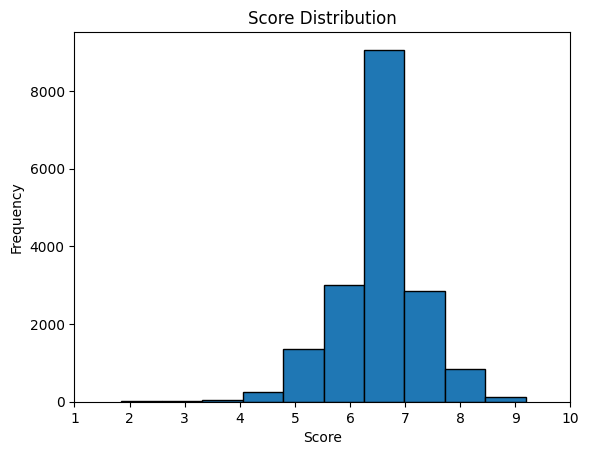

In [ ]:
plt.hist(anime_df['Score'], bins=10, edgecolor='black')

# Set the labels and title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')

# Set the x-axis limits and ticks
plt.xlim(1, 10)
plt.xticks(range(1, 11))

# Display the plot
plt.show()

## Top 20 Anime berdasarkan Score

In [ ]:
anime_df[raw_anime_mask].sort_values(by='Score', ascending=False).head(20)

,Name,Score,Genres,Type,Episodes,Aired,Premiered
3971,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009
15926,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",TV,16,"Dec 7, 2020 to ?",Winter 2021
5683,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011
14963,Shingeki no Kyojin Season 3 Part 2,9.10,"Action, Drama, Fantasy, Military, Mystery, Sho...",TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019
6474,Hunter x Hunter (2011),9.10,"Action, Adventure, Fantasy, Shounen, Super Power",TV,148,"Oct 2, 2011 to Sep 24, 2014",Fall 2011
9913,Gintama°,9.10,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015
6006,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",TV,51,"Apr 4, 2011 to Mar 26, 2012",Spring 2011
741,Ginga Eiyuu Densetsu,9.07,"Military, Sci-Fi, Space, Drama",OVA,110,"Jan 8, 1988 to Mar 17, 1997",Unknown
7261,Gintama': Enchousen,9.04,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,"Oct 4, 2012 to Mar 28, 2013",Fall 2012
12898,3-gatsu no Lion 2nd Season,9.00,"Drama, Game, Seinen, Slice of Life",TV,22,"Oct 14, 2017 to Mar 31, 2018",Fall 2017


In [ ]:
print(anime_df[raw_anime_mask].sort_values(by='Score', ascending=False).head(20).to_markdown())

|       | Name                                                       |   Score | Genres                                                              | Type   |   Episodes | Aired                        | Premiered   |
|------:|:-----------------------------------------------------------|--------:|:--------------------------------------------------------------------|:-------|-----------:|:-----------------------------|:------------|
|  3971 | Fullmetal Alchemist: Brotherhood                           |    9.19 | Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen | TV     |         64 | Apr 5, 2009 to Jul 4, 2010   | Spring 2009 |
| 15926 | Shingeki no Kyojin: The Final Season                       |    9.17 | Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen     | TV     |         16 | Dec 7, 2020 to ?             | Winter 2021 |
|  5683 | Steins;Gate                                                |    9.11 | Thriller, Sci-Fi                               

## Deskripsi Kolom Score dan Members

In [ ]:
anime_df[['Score', 'Members']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Score,Members
count,17562.00000,17562.00000
mean,6.51000,34658.53952
std,0.74571,125282.14143
min,1.85000,1.00000
25%,6.20000,336.00000
50%,6.51000,2065.00000
75%,6.86000,13223.25000
max,9.19000,2589552.00000


In [ ]:
print(anime_df[['Score', 'Members']].describe().apply(lambda s: s.apply('{0:.5f}'.format)).to_markdown())

|       |       Score |          Members |
|:------|------------:|-----------------:|
| count | 17562       |  17562           |
| mean  |     6.51    |  34658.5         |
| std   |     0.74571 | 125282           |
| min   |     1.85    |      1           |
| 25%   |     6.2     |    336           |
| 50%   |     6.51    |   2065           |
| 75%   |     6.86    |  13223.2         |
| max   |     9.19    |      2.58955e+06 |


## Genres Feature

In [ ]:
def showGenreList(df):
    # Split the genres in each row and create a list of individual genres
    genre_lists = df['Genres'].str.split(', ')

    # Flatten the list of lists
    flattened_genres = [genre for genres in genre_lists for genre in genres]

    # Get the unique genres
    unique_genres = pd.Series(flattened_genres).unique()

    # Display the unique genres
    print(unique_genres)

    print("\nTotal\n")
    print(df['Genres'].str.split(', ').explode().value_counts().to_markdown())

In [ ]:
def showGenrePlot(df):
  # Count the occurrences of each genre
  genre_counts = df['Genres'].str.split(', ').explode().value_counts()

  # Create the bar plot
  plt.figure(figsize=(15, 6))
  plt.bar(genre_counts.index, genre_counts.values, width=0.6)

  # Set the labels and title
  plt.xlabel('Genre')
  plt.ylabel('Count')
  plt.title('Genre Distribution')

  # Rotate the x-axis labels for better readability
  plt.xticks(rotation=90)

  # Display the plot
  plt.show()

In [ ]:
showGenreList(anime_df)

['Action' 'Adventure' 'Comedy' 'Drama' 'Sci-Fi' 'Space' 'Mystery'
 'Shounen' 'Police' 'Supernatural' 'Magic' 'Fantasy' 'Sports' 'Josei'
 'Romance' 'Slice of Life' 'Cars' 'Seinen' 'Horror' 'Psychological'
 'Thriller' 'Super Power' 'Martial Arts' 'School' 'Ecchi' 'Vampire'
 'Military' 'Historical' 'Dementia' 'Mecha' 'Demons' 'Samurai' 'Game'
 'Shoujo' 'Harem' 'Music' 'Shoujo Ai' 'Shounen Ai' 'Kids' 'Hentai'
 'Parody' 'Yuri' 'Yaoi' 'Unknown']

Total

|               |   Genres |
|:--------------|---------:|
| Comedy        |     6029 |
| Action        |     3888 |
| Fantasy       |     3285 |
| Adventure     |     2957 |
| Kids          |     2665 |
| Drama         |     2619 |
| Sci-Fi        |     2583 |
| Music         |     2244 |
| Shounen       |     2003 |
| Slice of Life |     1914 |
| Romance       |     1899 |
| School        |     1642 |
| Supernatural  |     1479 |
| Hentai        |     1348 |
| Historical    |     1144 |
| Mecha         |     1101 |
| Magic         |     1081

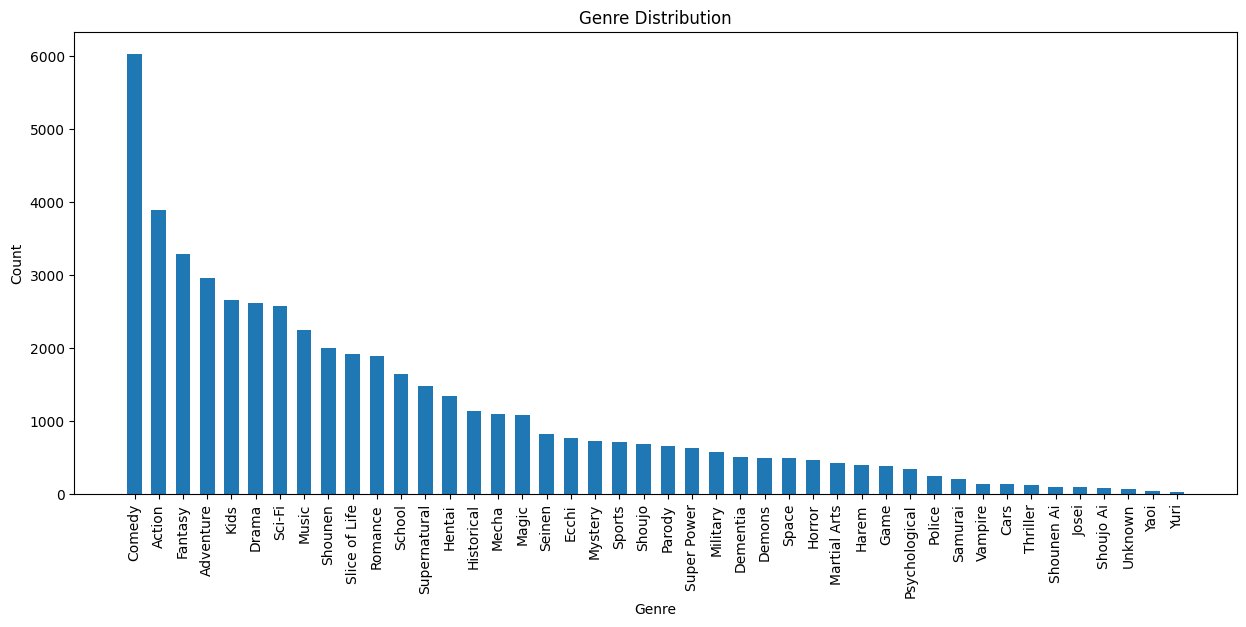

In [ ]:
showGenrePlot(anime_df)

## Type Feature

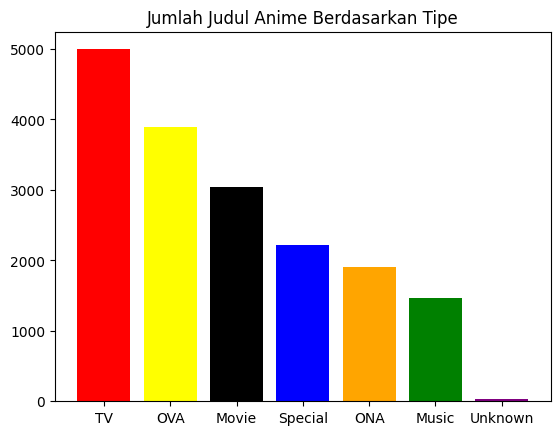

In [ ]:
type_counts = anime_df['Type'].value_counts()

# Create a bar chart
plt.bar(type_counts.index, type_counts.values, color = ['red', 'yellow', 'black', 'blue', 'orange', 'green', 'purple'])
plt.title('Jumlah Judul Anime Berdasarkan Tipe')

plt.show()

In [ ]:
print("Jumlah judul anime berdasarkan tipe")
print(anime_df['Type'].value_counts().to_markdown())
print("\nJumlah judul anime berdasarkan tipe")
print((100*anime_df['Type'].value_counts(normalize=True)).to_markdown())

Jumlah judul anime berdasarkan tipe
|         |   Type |
|:--------|-------:|
| TV      |   4996 |
| OVA     |   3894 |
| Movie   |   3041 |
| Special |   2218 |
| ONA     |   1907 |
| Music   |   1469 |
| Unknown |     37 |

Jumlah judul anime berdasarkan tipe
|         |      Type |
|:--------|----------:|
| TV      | 28.4478   |
| OVA     | 22.1729   |
| Movie   | 17.3158   |
| Special | 12.6295   |
| ONA     | 10.8587   |
| Music   |  8.36465  |
| Unknown |  0.210682 |


## Watching Status Feature

In [ ]:
anime_list_df.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [ ]:
for index, row in watching_status_df.iterrows():
  print(row.status, row[' description'])

1 Currently Watching
2 Completed
3 On Hold
4 Dropped
6 Plan to Watch


In [ ]:
anime_list_df['watching_status'].unique()

array([ 1,  2,  3,  4,  6,  0,  5, 33, 55])

In [ ]:
print(anime_list_df['watching_status'].value_counts().to_markdown())

|    |   watching_status |
|---:|------------------:|
|  2 |       6.80898e+07 |
|  6 |       2.79387e+07 |
|  1 |       5.22866e+06 |
|  4 |       4.26659e+06 |
|  3 |       3.70051e+06 |
|  0 |     531           |
|  5 |       6           |
| 33 |       2           |
| 55 |       1           |


## Normalisasi ID Watching Status

In [ ]:
# Ubah id 5 menjadi 6 (ambil yang terdekat)
anime_list_df['watching_status'] = anime_list_df['watching_status'].replace(
    5, 6
)

# Ubah id 33 menjadi 3
anime_list_df['watching_status'] = anime_list_df['watching_status'].replace(
    33, 3
)

# Ubah id 55 menjadi 6
anime_list_df['watching_status'] = anime_list_df['watching_status'].replace(
    55, 6
)

In [ ]:
anime_list_df['watching_status'].unique()

array([1, 2, 3, 4, 6, 0])

In [ ]:
print(anime_list_df['watching_status'].value_counts().to_markdown())

|    |   watching_status |
|---:|------------------:|
|  2 |       6.80898e+07 |
|  6 |       2.79387e+07 |
|  1 |       5.22866e+06 |
|  4 |       4.26659e+06 |
|  3 |       3.70052e+06 |
|  0 |     531           |


### Periksa data dengan ID Watching Status 0

In [ ]:
anime_list_df.loc[anime_list_df['watching_status'] == 0].head()

,user_id,anime_id,rating,watching_status,watched_episodes
2970875,10015,6682,0,0,0
2970876,10015,18893,0,0,0
2970877,10015,4999,0,0,0
2970878,10015,7817,0,0,0
2970879,10015,6347,0,0,0


In [ ]:
print(anime_list_df.loc[anime_list_df['watching_status'] == 0].head().to_markdown())

|         |   user_id |   anime_id |   rating |   watching_status |   watched_episodes |
|--------:|----------:|-----------:|---------:|------------------:|-------------------:|
| 2970875 |     10015 |       6682 |        0 |                 0 |                  0 |
| 2970876 |     10015 |      18893 |        0 |                 0 |                  0 |
| 2970877 |     10015 |       4999 |        0 |                 0 |                  0 |
| 2970878 |     10015 |       7817 |        0 |                 0 |                  0 |
| 2970879 |     10015 |       6347 |        0 |                 0 |                  0 |


In [ ]:
print(anime_list_df[['rating', 'watching_status', 'watched_episodes']].loc[anime_list_df['watching_status'] == 0].describe().to_markdown())

|       |    rating |   watching_status |   watched_episodes |
|:------|----------:|------------------:|-------------------:|
| count | 531       |               531 |          531       |
| mean  |   1.30508 |                 0 |            4.66478 |
| std   |   3.23033 |                 0 |           25.3202  |
| min   |   0       |                 0 |            0       |
| 25%   |   0       |                 0 |            0       |
| 50%   |   0       |                 0 |            0       |
| 75%   |   0       |                 0 |            0       |
| max   |  10       |                 0 |          345       |


In [ ]:
print(anime_list_df[['rating', 'watching_status', 'watched_episodes']].loc[
    (anime_list_df['watching_status'] == 0)
    & ((anime_list_df['rating'] > 0) |
      (anime_list_df['watched_episodes'] > 0))].head().to_markdown())

|         |   rating |   watching_status |   watched_episodes |
|--------:|---------:|------------------:|-------------------:|
| 2970880 |        0 |                 0 |                  5 |
| 2970881 |        0 |                 0 |                  6 |
| 2970882 |        7 |                 0 |                  2 |
| 2970886 |       10 |                 0 |                 12 |
| 2970889 |       10 |                 0 |                 13 |


In [ ]:
len(anime_list_df)

109224747

In [ ]:
anime_list_df = anime_list_df[anime_list_df['watching_status'] != 0]

In [ ]:
len(anime_list_df)

109224216

### Ubah 'watching_status' dari ID menjadi sesuai 'description' di watching_status_df

In [ ]:
for index, row in watching_status_df.iterrows():
  anime_list_df.loc[:, 'watching_status'] = anime_list_df['watching_status'].replace(
      row.status, row[' description'])

In [ ]:
## Clear Memory
del watching_status_df

Jumlah user terhadap status tonton
Completed             68089751
Plan to Watch         27938700
Currently Watching     5228658
Dropped                4266591
On Hold                3700516
Name: watching_status, dtype: int64

Persentase jumlah user terhadap status tonton
|                    |   watching_status |
|:-------------------|------------------:|
| Completed          |          62.3394  |
| Plan to Watch      |          25.5792  |
| Currently Watching |           4.78709 |
| Dropped            |           3.90627 |
| On Hold            |           3.388   |

Diagram


<AxesSubplot: title={'center': 'Watching Status'}>

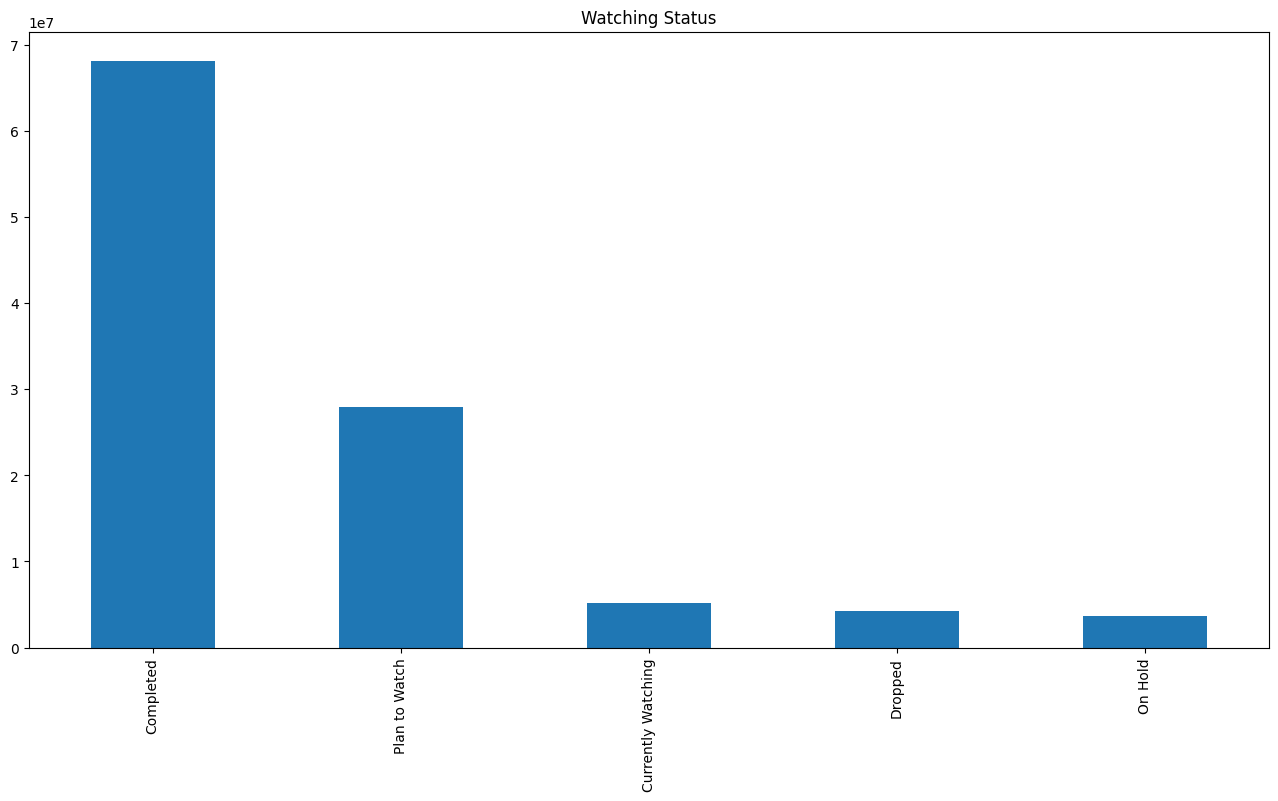

In [ ]:
print("Jumlah user terhadap status tonton")
with pd.option_context('display.float_format', '{:.0f}'.format):
    count = anime_list_df['watching_status'].value_counts()
print(count)
print("\nPersentase jumlah user terhadap status tonton")
print((100*anime_list_df['watching_status'].value_counts(normalize=True)).to_markdown())
print("\nDiagram")
anime_list_df['watching_status'].value_counts().plot(kind='bar', title='Watching Status', figsize=(16,8))

# Data Preparation

## Hapus Anime dengan Genre Tertentu

In [ ]:
## Hapus list anime dengan genre "dewasa" dan "Unknown"
genres_to_remove = ['Hentai', 'Yuri', 'Yaoi', 'Shounen Ai',
                    'Shoujo Ai', 'Ecchi', 'Unknown']
mask = anime_df['Genres'].str.contains('|'.join(genres_to_remove))
anime_df = anime_df[~mask]

In [ ]:
showGenreList(anime_df)

['Action' 'Adventure' 'Comedy' 'Drama' 'Sci-Fi' 'Space' 'Mystery'
 'Shounen' 'Police' 'Supernatural' 'Magic' 'Fantasy' 'Sports' 'Josei'
 'Romance' 'Slice of Life' 'Cars' 'Seinen' 'Horror' 'Psychological'
 'Thriller' 'Super Power' 'Martial Arts' 'School' 'Vampire' 'Military'
 'Historical' 'Dementia' 'Mecha' 'Demons' 'Samurai' 'Game' 'Shoujo'
 'Harem' 'Music' 'Kids' 'Parody']

Total

|               |   Genres |
|:--------------|---------:|
| Comedy        |     5345 |
| Action        |     3606 |
| Fantasy       |     3020 |
| Adventure     |     2861 |
| Kids          |     2662 |
| Drama         |     2448 |
| Sci-Fi        |     2420 |
| Music         |     2217 |
| Shounen       |     1870 |
| Slice of Life |     1824 |
| Romance       |     1482 |
| School        |     1296 |
| Supernatural  |     1280 |
| Historical    |     1112 |
| Mecha         |     1056 |
| Magic         |      948 |
| Seinen        |      724 |
| Mystery       |      705 |
| Sports        |      678 |
| Shou

In [ ]:
len(anime_df)

15191

## Hapus Kolom yang Tidak Dibutuhkan di variabel anime

In [ ]:
anime_df = anime_df[['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Members']]

## Gabungkan Data Anime dengan Sinopsis

In [ ]:
anime_df = anime_df.merge(anime_sypnopsis_df[['MAL_ID', 'sypnopsis']], on='MAL_ID')
anime_df.head()

,MAL_ID,Name,Score,Genres,Type,Members,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,1251960,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,273145,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,558913,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,94683,ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,13224,It is the dark century and the people are suff...


In [ ]:
print(anime_df.head().to_markdown())

|    |   MAL_ID | Name                            |   Score | Genres                                              | Type   |   Members | sypnopsis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Data Preparation Untuk Content Based Filtering

### Filter Daftar Anime Berdasarkan Jumlah Members

In [ ]:
anime_top_df = anime_df.loc[anime_df['Members'] >= 34658]
len(anime_top_df)

2362

In [ ]:
anime_top_df.head()

,MAL_ID,Name,Score,Genres,Type,Members,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,1251960,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,273145,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,558913,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,94683,ches are individuals with special powers like ...
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",TV,148259,Sena is like any other shy kid starting high s...


In [ ]:
print(anime_top_df.head().to_markdown())

|    |   MAL_ID | Name                            |   Score | Genres                                              | Type   |   Members | sypnopsis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Data Preparation Untuk Colaborative Filtering

### Filter Ranking User Jika User Telah Menamatkan atau Berhenti Menonton Anime Tersebut

In [ ]:
anime_list_df = anime_list_df.loc[anime_list_df['watching_status'].isin(['Completed', 'Dropped'])]

In [ ]:
anime_list_df['watching_status'].unique()

array(['Completed', 'Dropped'], dtype=object)

### Cek Data yang NaN

In [ ]:
print(anime_list_df.isnull().sum().to_markdown())

|                  |   0 |
|:-----------------|----:|
| user_id          |   0 |
| anime_id         |   0 |
| rating           |   0 |
| watching_status  |   0 |
| watched_episodes |   0 |
| user             |   0 |
| anime            |   0 |


### Encode Fitur user_id dan anime_id

In [ ]:
# Mengubah anime_id menjadi list tanpa nilai yang sama
user_ids = anime_list_df.user_id.unique().tolist()
# Melakukan encoding anime_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
# Melakukan proses encoding angka ke ke anime_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [ ]:
# Mengubah anime_id menjadi list tanpa nilai yang sama
anime_ids = anime_list_df.anime_id.unique().tolist()
# Melakukan proses encoding anime_id
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
# Melakukan proses encoding angka ke anime_id
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

In [ ]:
# Mapping user_id ke dataframe user
anime_list_df['user'] = anime_list_df['user_id'].map(user_to_user_encoded)

# Mapping anime_id ke dataframe anime
anime_list_df['anime'] = anime_list_df['anime_id'].map(anime_to_anime_encoded)

In [ ]:
anime_list_df.head()

,user_id,anime_id,rating,watching_status,watched_episodes,user,anime
11,0,68,6,Completed,23,0,0
12,0,1689,6,Completed,3,0,1
13,0,2913,6,Completed,40,0,2
14,0,1250,7,Completed,26,0,3
15,0,356,9,Completed,24,0,4


In [ ]:
print(anime_list_df.head().to_markdown())

|    |   user_id |   anime_id |   rating | watching_status   |   watched_episodes |   user |   anime |
|---:|----------:|-----------:|---------:|:------------------|-------------------:|-------:|--------:|
| 11 |         0 |         68 |        6 | Completed         |                 23 |      0 |       0 |
| 12 |         0 |       1689 |        6 | Completed         |                  3 |      0 |       1 |
| 13 |         0 |       2913 |        6 | Completed         |                 40 |      0 |       2 |
| 14 |         0 |       1250 |        7 | Completed         |                 26 |      0 |       3 |
| 15 |         0 |        356 |        9 | Completed         |                 24 |      0 |       4 |


### Convert Fitur Rating

In [ ]:
anime_list_df['rating'] = anime_list_df['rating'].astype('float64')
anime_list_df.head()

,user_id,anime_id,rating,watching_status,watched_episodes,user,anime
11,0,68,6.0,Completed,23,0,0
12,0,1689,6.0,Completed,3,0,1
13,0,2913,6.0,Completed,40,0,2
14,0,1250,7.0,Completed,26,0,3
15,0,356,9.0,Completed,24,0,4


In [ ]:
anime_list_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72356342 entries, 11 to 109224745
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           int64  
 1   anime_id          int64  
 2   rating            float64
 3   watching_status   object 
 4   watched_episodes  int64  
 5   user              int64  
 6   anime             int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 4.3+ GB


### Periksa Jumlah Data User, Anime dan Rating Minimum dan Maksimum

In [ ]:
min_rating = min(anime_list_df['rating'])
max_rating = max(anime_list_df['rating'])
num_users = len(user_to_user_encoded)
num_animes = len(anime_to_anime_encoded)

print('Number of User: {}, Number of Animes: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_animes,
    min_rating, max_rating
))

Number of User: 320950, Number of Animes: 17183, Min Rating: 0, Max Rating: 10


### Train-Test Split

In [ ]:
## Acak data
anime_list_df = anime_list_df.sample(frac=1, random_state=42)
anime_list_df.head()

,user_id,anime_id,rating,watching_status,watched_episodes,user,anime
107692276,348412,9989,8.0,Completed,11,316404,200
11673591,37980,32998,7.0,Completed,12,34462,189
16255037,52735,226,9.0,Completed,13,47868,155
81026631,262362,22135,7.0,Completed,11,238365,1135
50087209,162477,256,9.0,Completed,1,147496,582


In [ ]:
print(anime_list_df.head().to_markdown())

|           |   user_id |   anime_id |   rating | watching_status   |   watched_episodes |   user |   anime |
|----------:|----------:|-----------:|---------:|:------------------|-------------------:|-------:|--------:|
| 107692276 |    348412 |       9989 |        8 | Completed         |                 11 | 316404 |     200 |
|  11673591 |     37980 |      32998 |        7 | Completed         |                 12 |  34462 |     189 |
|  16255037 |     52735 |        226 |        9 | Completed         |                 13 |  47868 |     155 |
|  81026631 |    262362 |      22135 |        7 | Completed         |                 11 | 238365 |    1135 |
|  50087209 |    162477 |        256 |        9 | Completed         |                  1 | 147496 |     582 |


In [ ]:
# Membuat variabel x untuk mencocokkan data user dan anime menjadi satu value
x = anime_list_df[['user', 'anime']].values

# Membuat variabel y untuk membuat rating dari hasil
y = anime_list_df['rating'].apply(lambda x: (
    x - min_rating) / (
    max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * anime_list_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[316404    200]
 [ 34462    189]
 [ 47868    155]
 ...
 [252446  12829]
 [251929   1311]
 [291258    577]] [0.8 0.7 0.9 ... 0.4 0.5 0.6]


# Modelling

## Content Based Filtering

### TF-IDF Vectorizer

In [ ]:
# Inisialisasi TfidfVectorizer
tfid = TfidfVectorizer(tokenizer=lambda x: x.lower().split(', '))

# Melakukan perhitungan idf pada data Genre
tfid.fit(anime_top_df['Genres'])

# Mapping array dari fitur index integer ke fitur judul anime
tfid.get_feature_names_out()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['action', 'adventure', 'cars', 'comedy', 'dementia', 'demons',
       'drama', 'fantasy', 'game', 'harem', 'historical', 'horror',
       'josei', 'kids', 'magic', 'martial arts', 'mecha', 'military',
       'music', 'mystery', 'parody', 'police', 'psychological', 'romance',
       'samurai', 'school', 'sci-fi', 'seinen', 'shoujo', 'shounen',
       'slice of life', 'space', 'sports', 'super power', 'supernatural',
       'thriller', 'vampire'], dtype=object)

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfid.fit_transform(anime_top_df['Genres'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(2362, 37)

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre
# Baris diisi dengan judul anime

tfid_example = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=anime_top_df.Name
).sample(22, axis=1).sample(10, axis=0)

tfid_example

,mystery,psychological,fantasy,parody,horror,demons,shounen,romance,magic,historical,...,shoujo,drama,military,martial arts,sci-fi,dementia,slice of life,school,space,music
Name,,,,,,,,,,,,,,,,,,,,,
Non Non Biyori Movie: Vacation,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.591009,0.000000,0.000000,0.0
Kizumonogatari II: Nekketsu-hen,0.484082,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Mobile Suit Gundam SEED Destiny,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.289756,0.0,0.000000,...,0.0,0.267906,0.446671,0.0,0.316291,0.0,0.000000,0.000000,0.550729,0.0
Hoshi wo Ou Kodomo,0.000000,0.0,0.544500,0.0,0.0,0.0,0.000000,0.588908,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Soredemo Machi wa Mawatteiru,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.591009,0.000000,0.000000,0.0
Non Non Biyori: Okinawa e Ikukoto ni Natta,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.517628,0.482604,0.000000,0.0
Nana Maru San Batsu,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.424736,0.000000,0.0
Nisekoi:,0.000000,0.0,0.000000,0.0,0.0,0.0,0.372698,0.386251,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.402636,0.000000,0.0
Mushishi: Hihamukage,0.402827,0.0,0.292893,0.0,0.0,0.0,0.000000,0.000000,0.0,0.488331,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.354184,0.000000,0.000000,0.0


In [ ]:
tfid_example.to_markdown()

'| Name                                       |   mystery |   psychological |   fantasy |   parody |   horror |   demons |   shounen |   romance |   magic |   historical |    harem |   thriller |   shoujo |    drama |   military |   martial arts |   sci-fi |   dementia |   slice of life |   school |    space |   music |\n|:-------------------------------------------|----------:|----------------:|----------:|---------:|---------:|---------:|----------:|----------:|--------:|-------------:|---------:|-----------:|---------:|---------:|-----------:|---------------:|---------:|-----------:|----------------:|---------:|---------:|--------:|\n| Non Non Biyori Movie: Vacation             |  0        |               0 |  0        |        0 |        0 |        0 |  0        |  0        |       0 |     0        | 0        |          0 |        0 | 0        |   0        |              0 | 0        |          0 |        0.591009 | 0        | 0        |       0 |\n| Kizumonogatari II: Nekketsu-hen

### Cosine Similarity

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime_top_df.Name, columns=anime_top_df.Name)

In [ ]:
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Name,Love Live! School Idol Project,Kannagi,No Guns Life,Black Blood Brothers,"Kimi to Boku no Saigo no Senjou, Aruiwa Sekai ga Hajimaru Seisen"
Name,,,,,
Pokemon Advanced Generation,0.000000,0.104577,0.103093,0.266414,0.244519
Kuma Kuma Kuma Bear,0.000000,0.180126,0.000000,0.323371,0.250868
Gintama': Enchousen,0.000000,0.215672,0.235477,0.207030,0.073965
Kengan Ashura,0.000000,0.000000,0.137066,0.104598,0.131453
Arslan Senki (TV): Fuujin Ranbu,0.000000,0.375775,0.246409,0.446213,0.236320
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka II: Past & Future,0.000000,0.161728,0.159433,0.412009,0.378149
Piano no Mori (TV),0.625337,0.292647,0.432491,0.065914,0.000000
Dragon Quest: Dai no Daibouken (2020),0.000000,0.266809,0.149719,0.465870,0.355109
Tokyo Majin Gakuen Kenpucho: Tou,0.140733,0.342343,0.208058,0.273763,0.199539


In [ ]:
print(cosine_sim_df.sample(5, axis=1).sample(10, axis=0).to_markdown())

| Name                                                  |   Innocence |   Ore wo Suki nano wa Omae dake ka yo |   Arakawa Under the Bridge x Bridge |   Ixion Saga DT |   Takanashi Rikka Kai: Chuunibyou demo Koi ga Shitai! Movie |
|:------------------------------------------------------|------------:|--------------------------------------:|------------------------------------:|----------------:|------------------------------------------------------------:|
| Kizumonogatari I: Tekketsu-hen                        |    0        |                             0         |                            0        |        0        |                                                   0         |
| Hakushaku to Yousei                                   |    0        |                             0.135105  |                            0.177902 |        0.197938 |                                                   0.149377  |
| D.N.Angel                                             |    0        |         

### Euclidean Distance

In [ ]:
# Menghitung euclidean distance pada matrix tf-idf
euclidean_dist = euclidean_distances(tfidf_matrix)
# Membuat dataframe dari variabel euclidean_dist dengan baris dan kolom berupa judul anime
euclidean_dist_df = pd.DataFrame(euclidean_dist, index=anime_top_df.Name, columns=anime_top_df.Name)

In [ ]:
euclidean_dist_df.sample(5, axis=1).sample(10, axis=0)

Name,Death Parade,Free!,Full Metal Panic! The Second Raid Episode 00,One Piece,Selector Infected WIXOSS
Name,,,,,
Scrapped Princess,1.347704,1.265230,1.021395,0.911582,1.414214
Saiki Kusuo no Ψ-nan,1.414214,0.978960,1.414214,1.219553,1.414214
Air Movie,1.304092,1.264291,1.414214,1.269719,1.414214
Overlord Movie 2: Shikkoku no Eiyuu,1.146104,1.414214,1.352750,1.262244,1.000857
Pokemon Movie 13: Genei no Hasha Zoroark,1.414214,1.414214,1.225293,1.123183,1.414214
Lord El-Melloi II Sei no Jikenbo: Rail Zeppelin Grace Note,1.218987,1.414214,1.414214,1.283708,1.414214
Baka to Test to Shoukanjuu Specials,1.414214,1.140793,1.414214,1.333726,1.414214
Ore Monogatari!!,1.414214,1.336835,1.414214,1.339559,1.414214
Mobile Suit Gundam: Iron-Blooded Orphans 2nd Season,1.351176,1.328964,1.102041,1.273124,1.414214


In [ ]:
print(euclidean_dist_df.sample(5, axis=1).sample(10, axis=0).to_markdown())

| Name                           |   High Score Girl: Extra Stage |   Basilisk: Kouga Ninpou Chou |   Toaru Kagaku no Railgun: Motto Marutto Railgun |   Digimon Adventure tri. 3: Kokuhaku |   School Rumble |
|:-------------------------------|-------------------------------:|------------------------------:|-------------------------------------------------:|-------------------------------------:|----------------:|
| Noragami OVA                   |                        1.34527 |                       1.10114 |                                          1.13214 |                             0.8834   |        1.11117  |
| Digimon Savers                 |                        1.34603 |                       1.20249 |                                          1.13556 |                             0.79917  |        1.11487  |
| Otome Youkai Zakuro            |                        1.17976 |                       1.09781 |                                          1.41421 |                  

## Collaborative Filtering

### RecommenderNet Model 1

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = tf.keras.layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.user_bias = tf.keras.layers.Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = tf.keras.layers.Embedding( # layer embeddings anime
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.anime_bias = tf.keras.layers.Embedding(num_anime, 1) # layer embedding anime bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model_v1_1 = RecommenderNet(num_users, num_animes, 50)
model_v1_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
callbacks_1_1=[
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor ='val_root_mean_squared_error' ,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/notebooks/model_1_1/cp.ckpt',
        'val_root_mean_squared_error', 1, True, True),
]

In [ ]:
history_v1_1 = model_v1_1.fit(
    x = x_train,
    y = y_train,
    batch_size = 8192,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=callbacks_1_1,
    verbose=1
)

Epoch 1/100
7066/7067 [============================>.] - ETA: 0s - loss: 1.5438 - root_mean_squared_error: 0.4659
Epoch 1: val_root_mean_squared_error improved from inf to 0.50843, saving model to /notebooks/model_1_1/cp.ckpt
7067/7067 [==============================] - 97s 13ms/step - loss: 1.5438 - root_mean_squared_error: 0.4659 - val_loss: 2.3687 - val_root_mean_squared_error: 0.5084
Epoch 2/100
7067/7067 [==============================] - ETA: 0s - loss: 3.0567 - root_mean_squared_error: 0.5198
Epoch 2: val_root_mean_squared_error did not improve from 0.50843
7067/7067 [==============================] - 91s 13ms/step - loss: 3.0567 - root_mean_squared_error: 0.5198 - val_loss: 3.5174 - val_root_mean_squared_error: 0.5263
Epoch 3/100
7065/7067 [============================>.] - ETA: 0s - loss: 4.3034 - root_mean_squared_error: 0.5316
Epoch 3: val_root_mean_squared_error did not improve from 0.50843
7067/7067 [==============================] - 90s 13ms/step - loss: 4.3036 - root_mea

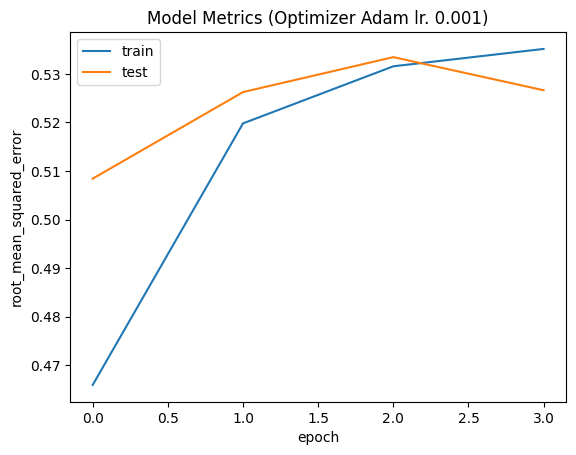

In [ ]:
plt.plot(history_v1_1.history['root_mean_squared_error'])
plt.plot(history_v1_1.history['val_root_mean_squared_error'])
plt.title('Model Metrics (Optimizer Adam lr. 0.001)')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_v1_2 = RecommenderNet(num_users, num_animes, 50)
model_v1_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.optimizers.RMSprop(1e-4),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
callbacks_1_2=[
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor ='val_root_mean_squared_error' ,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/notebooks/model_1_2/cp.ckpt',
        'val_root_mean_squared_error', 1, True, True),
]

In [ ]:
history_v1_2 = model_v1_2.fit(
    x = x_train,
    y = y_train,
    batch_size = 8192,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=callbacks_1_2,
    verbose=1
)

Epoch 1/100
7064/7067 [============================>.] - ETA: 0s - loss: 0.6561 - root_mean_squared_error: 0.3165
Epoch 1: val_root_mean_squared_error improved from inf to 0.30752, saving model to /notebooks/model_1_2/cp.ckpt
7067/7067 [==============================] - 121s 17ms/step - loss: 0.6561 - root_mean_squared_error: 0.3165 - val_loss: 0.6443 - val_root_mean_squared_error: 0.3075
Epoch 2/100
7064/7067 [============================>.] - ETA: 0s - loss: 0.6369 - root_mean_squared_error: 0.3018
Epoch 2: val_root_mean_squared_error improved from 0.30752 to 0.29681, saving model to /notebooks/model_1_2/cp.ckpt
7067/7067 [==============================] - 114s 16ms/step - loss: 0.6369 - root_mean_squared_error: 0.3018 - val_loss: 0.6306 - val_root_mean_squared_error: 0.2968
Epoch 3/100
7065/7067 [============================>.] - ETA: 0s - loss: 0.6253 - root_mean_squared_error: 0.2926
Epoch 3: val_root_mean_squared_error improved from 0.29681 to 0.28885, saving model to /notebooks/

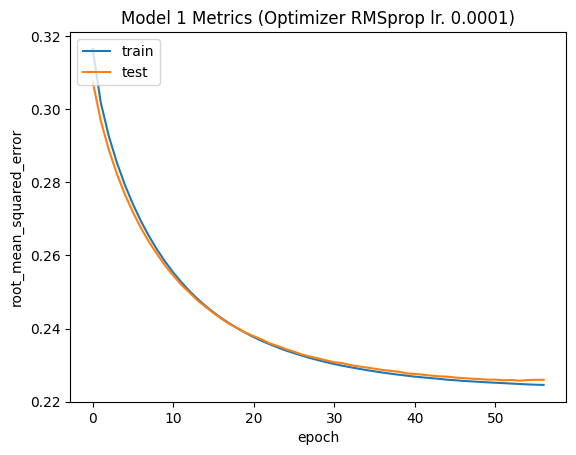

In [ ]:
plt.plot(history_v1_2.history['root_mean_squared_error'])
plt.plot(history_v1_2.history['val_root_mean_squared_error'])
plt.title('Model 1 Metrics (Optimizer RMSprop lr. 0.0001)')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation

## Content Based Filtering

### Create Prediction Function

In [ ]:
anime_columns = ['MAL_ID', 'Name', 'Score', 'Genres', 'Type']
def get_recommendations(title, similarity_data=cosine_sim_df, similar_type='cosine', items=anime_top_df[anime_columns], k=10):
    """
    Rekomendasi Resto berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_resto : tipe data string (str)
                Nama Restoran (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)


    # Mengambil data dengan similarity terbesar (cosine) dan terkecil (euclidean) dari index yang ada
    if (similar_type == 'cosine'):
        index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
        closest = similarity_data.columns[index[-1:-(k+2):-1]]
        score = similarity_data.iloc[index[-1:-(k+2):-1],
                                     similarity_data.columns.get_loc(title)
                                    ].reset_index(drop=True)
    else:
        index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(k+1))
        closest = similarity_data.columns[index[:(k+2)]]
        score = similarity_data.iloc[index[:(k+2)],
                                     similarity_data.columns.get_loc(title)
                                    ].reset_index(drop=True)

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')
    result = pd.DataFrame(closest).merge(items).head(k)
    result['score'] = score
    return result

#### Example Titles

In [ ]:
anime_top_df.loc[anime_top_df.Name.isin([
    'Clannad: After Story',
    'Non Non Biyori',
    'Sword Art Online',
    'Kuma Kuma Kuma Bear',
    'Gochuumon wa Usagi Desu ka?'
]), anime_columns]

,MAL_ID,Name,Score,Genres,Type
2839,4181,Clannad: After Story,8.96,"Slice of Life, Comedy, Supernatural, Drama, Ro...",TV
5283,11757,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",TV
6192,17549,Non Non Biyori,7.95,"Comedy, School, Seinen, Slice of Life",TV
6845,21273,Gochuumon wa Usagi Desu ka?,7.52,"Slice of Life, Comedy",TV
14178,40974,Kuma Kuma Kuma Bear,7.14,"Adventure, Comedy, Fantasy",TV


In [ ]:
print(anime_top_df.loc[anime_top_df.Name.isin([
    'Clannad: After Story',
    'Non Non Biyori',
    'Sword Art Online',
    'Kuma Kuma Kuma Bear',
    'Gochuumon wa Usagi Desu ka?'
]), anime_columns].to_markdown())

|       |   MAL_ID | Name                        |   Score | Genres                                              | Type   |
|------:|---------:|:----------------------------|--------:|:----------------------------------------------------|:-------|
|  2839 |     4181 | Clannad: After Story        |    8.96 | Slice of Life, Comedy, Supernatural, Drama, Romance | TV     |
|  5283 |    11757 | Sword Art Online            |    7.25 | Action, Game, Adventure, Romance, Fantasy           | TV     |
|  6192 |    17549 | Non Non Biyori              |    7.95 | Comedy, School, Seinen, Slice of Life               | TV     |
|  6845 |    21273 | Gochuumon wa Usagi Desu ka? |    7.52 | Slice of Life, Comedy                               | TV     |
| 14178 |    40974 | Kuma Kuma Kuma Bear         |    7.14 | Adventure, Comedy, Fantasy                          | TV     |


#### Cosine Similarity

In [ ]:
get_recommendations('Clannad: After Story')

,Name,MAL_ID,Score,Genres,Type,score
0,Kanon,144,7.11,"Drama, Romance, Slice of Life, Supernatural",TV,1.000000
1,Sola,1965,7.22,"Drama, Romance, Slice of Life, Supernatural",TV,0.941605
2,Kanon (2006),1530,8.01,"Slice of Life, Supernatural, Drama, Romance",TV,0.941605
3,Air,101,7.32,"Slice of Life, Supernatural, Drama, Romance",TV,0.941605
4,Sewayaki Kitsune no Senko-san,38759,7.36,"Slice of Life, Comedy, Supernatural, Romance",TV,0.941605
5,Little Busters!: EX,20517,7.74,"Slice of Life, Comedy, Supernatural, Drama, Ro...",Special,0.903943
6,Kokoro Connect,11887,7.82,"Slice of Life, Comedy, Supernatural, Drama, Ro...",TV,0.900766
7,Little Busters!: Refrain,18195,8.23,"Slice of Life, Comedy, Supernatural, Drama, Ro...",TV,0.900766
8,Clannad,2167,8.07,"Comedy, Drama, Romance, School, Slice of Life,...",TV,0.900766
9,Kokoro Connect: Michi Random,16001,8.01,"Comedy, Drama, Romance, School, Slice of Life,...",Special,0.900766


In [ ]:
print(get_recommendations('Clannad: After Story').to_markdown())

|    | Name                          |   MAL_ID |   Score | Genres                                                      | Type    |    score |
|---:|:------------------------------|---------:|--------:|:------------------------------------------------------------|:--------|---------:|
|  0 | Kanon                         |      144 |    7.11 | Drama, Romance, Slice of Life, Supernatural                 | TV      | 1        |
|  1 | Sola                          |     1965 |    7.22 | Drama, Romance, Slice of Life, Supernatural                 | TV      | 0.941605 |
|  2 | Kanon (2006)                  |     1530 |    8.01 | Slice of Life, Supernatural, Drama, Romance                 | TV      | 0.941605 |
|  3 | Air                           |      101 |    7.32 | Slice of Life, Supernatural, Drama, Romance                 | TV      | 0.941605 |
|  4 | Sewayaki Kitsune no Senko-san |    38759 |    7.36 | Slice of Life, Comedy, Supernatural, Romance                | TV      | 0.941605 |

In [ ]:
get_recommendations('Non Non Biyori')

,Name,MAL_ID,Score,Genres,Type,score
0,Hello!! Kiniro Mosaic,23269,7.53,"Slice of Life, Comedy, School, Seinen",TV,1.0
1,Himouto! Umaru-chan R,35376,7.36,"Comedy, School, Seinen, Slice of Life",TV,1.0
2,Non Non Biyori Repeat,23623,8.18,"Comedy, School, Seinen, Slice of Life",TV,1.0
3,A-Channel,9776,6.96,"Comedy, School, Seinen, Slice of Life",TV,1.0
4,Sakamoto Desu ga?,32542,7.59,"Slice of Life, Comedy, School, Seinen",TV,1.0
5,Hidamari Sketch,1852,7.45,"Comedy, School, Seinen, Slice of Life",TV,1.0
6,Himouto! Umaru-chan,28825,7.17,"Comedy, School, Seinen, Slice of Life",TV,1.0
7,Non Non Biyori: Okinawa e Ikukoto ni Natta,21667,7.61,"Slice of Life, Comedy, School, Seinen",OVA,1.0
8,Himouto! Umaru-chan OVA,30991,7.25,"Slice of Life, Comedy, School, Seinen",OVA,1.0
9,Recorder to Randoseru Do♪,11491,6.69,"Comedy, School, Seinen, Slice of Life",TV,1.0


In [ ]:
print(get_recommendations('Non Non Biyori').to_markdown())

|    | Name                                       |   MAL_ID |   Score | Genres                                | Type   |   score |
|---:|:-------------------------------------------|---------:|--------:|:--------------------------------------|:-------|--------:|
|  0 | Hello!! Kiniro Mosaic                      |    23269 |    7.53 | Slice of Life, Comedy, School, Seinen | TV     |       1 |
|  1 | Himouto! Umaru-chan R                      |    35376 |    7.36 | Comedy, School, Seinen, Slice of Life | TV     |       1 |
|  2 | Non Non Biyori Repeat                      |    23623 |    8.18 | Comedy, School, Seinen, Slice of Life | TV     |       1 |
|  3 | A-Channel                                  |     9776 |    6.96 | Comedy, School, Seinen, Slice of Life | TV     |       1 |
|  4 | Sakamoto Desu ga?                          |    32542 |    7.59 | Slice of Life, Comedy, School, Seinen | TV     |       1 |
|  5 | Hidamari Sketch                            |     1852 |    7.45 | Com

In [ ]:
get_recommendations('Sword Art Online')

,Name,MAL_ID,Score,Genres,Type,score
0,Sword Art Online II,21881,6.79,"Action, Game, Adventure, Romance, Fantasy",TV,1.000000
1,Sword Art Online: Alicization,36474,7.57,"Action, Game, Adventure, Romance, Fantasy",TV,1.000000
2,Sword Art Online: Progressive Movie - Hoshi Na...,42916,Unknown,"Action, Game, Adventure, Romance, Fantasy",Movie,1.000000
3,Sword Art Online: Extra Edition,20021,6.61,"Action, Adventure, Fantasy, Game, Romance",Special,1.000000
4,Sword Art Online Movie: Ordinal Scale,31765,7.65,"Action, Game, Adventure, Romance, Fantasy",Movie,1.000000
5,Sword Art Online: Alicization - War of Underworld,39597,7.63,"Action, Game, Adventure, Romance, Fantasy",TV,1.000000
6,Sword Art Online: Alicization - War of Underwo...,40489,6.75,"Action, Game, Adventure, Romance, Fantasy",Special,1.000000
7,Sword Art Online: Alicization - War of Underwo...,40540,7.42,"Action, Game, Adventure, Romance, Fantasy",TV,1.000000
8,Sword Art Online II: Debriefing,27891,6.56,"Action, Adventure, Fantasy, Game",Special,1.000000
9,.hack//Quantum,9332,7.18,"Action, Adventure, Fantasy, Game, Sci-Fi",OVA,0.921154


In [ ]:
print(get_recommendations('Sword Art Online').to_markdown())

|    | Name                                                          |   MAL_ID | Score   | Genres                                    | Type    |    score |
|---:|:--------------------------------------------------------------|---------:|:--------|:------------------------------------------|:--------|---------:|
|  0 | Sword Art Online II                                           |    21881 | 6.79    | Action, Game, Adventure, Romance, Fantasy | TV      | 1        |
|  1 | Sword Art Online: Alicization                                 |    36474 | 7.57    | Action, Game, Adventure, Romance, Fantasy | TV      | 1        |
|  2 | Sword Art Online: Progressive Movie - Hoshi Naki Yoru no Aria |    42916 | Unknown | Action, Game, Adventure, Romance, Fantasy | Movie   | 1        |
|  3 | Sword Art Online: Extra Edition                               |    20021 | 6.61    | Action, Adventure, Fantasy, Game, Romance | Special | 1        |
|  4 | Sword Art Online Movie: Ordinal Scale              

In [ ]:
get_recommendations('Kuma Kuma Kuma Bear')

,Name,MAL_ID,Score,Genres,Type,score
0,Kemono Friends,33089,7.58,"Adventure, Comedy, Fantasy",TV,1.000000
1,Tsuujou Kougeki ga Zentai Kougeki de Ni-kai Ko...,38573,5.54,"Adventure, Comedy, Fantasy",TV,1.000000
2,"Kumo Desu ga, Nani ka?",37984,6.94,"Adventure, Comedy, Fantasy",TV,1.000000
3,Druaga no Tou: The Aegis of Uruk,3230,7.19,"Adventure, Comedy, Fantasy",TV,1.000000
4,Shinchou Yuusha: Kono Yuusha ga Ore Tueee Kuse...,38659,7.54,"Action, Adventure, Comedy, Fantasy",TV,1.000000
5,Hitsugi no Chaika OVA,24261,7.02,"Action, Adventure, Comedy, Fantasy",OVA,0.897860
6,Dungeon ni Deai wo Motomeru no wa Machigatteir...,40064,6.72,"Action, Adventure, Comedy, Fantasy",Special,0.897860
7,Monster Farm: Enbanseki no Himitsu,1469,6.82,"Action, Adventure, Comedy, Fantasy",TV,0.897860
8,Seisen Cerberus: Ryuukoku no Fatalités,32595,5.64,"Adventure, Fantasy",TV,0.897860
9,Druaga no Tou: The Sword of Uruk,4726,7.24,"Adventure, Fantasy",TV,0.883402


In [ ]:
print(get_recommendations('Kuma Kuma Kuma Bear').to_markdown())

|    | Name                                                                            |   MAL_ID |   Score | Genres                             | Type    |    score |
|---:|:--------------------------------------------------------------------------------|---------:|--------:|:-----------------------------------|:--------|---------:|
|  0 | Kemono Friends                                                                  |    33089 |    7.58 | Adventure, Comedy, Fantasy         | TV      | 1        |
|  1 | Tsuujou Kougeki ga Zentai Kougeki de Ni-kai Kougeki no Okaasan wa Suki Desu ka? |    38573 |    5.54 | Adventure, Comedy, Fantasy         | TV      | 1        |
|  2 | Kumo Desu ga, Nani ka?                                                          |    37984 |    6.94 | Adventure, Comedy, Fantasy         | TV      | 1        |
|  3 | Druaga no Tou: The Aegis of Uruk                                                |     3230 |    7.19 | Adventure, Comedy, Fantasy         | TV      | 1  

In [ ]:
get_recommendations('Gochuumon wa Usagi Desu ka?')

,Name,MAL_ID,Score,Genres,Type,score
0,Yuru Camp△ Specials,37341,7.53,"Slice of Life, Comedy",Special,1.0
1,Ooyasan wa Shishunki!,31621,6.56,"Comedy, Slice of Life",TV,1.0
2,Yuru Camp△,34798,8.27,"Slice of Life, Comedy",TV,1.0
3,Steins;Gate: Soumei Eichi no Cognitive Computing,27957,7.41,"Slice of Life, Comedy",ONA,1.0
4,Tamako Market,16417,7.38,"Slice of Life, Comedy",TV,1.0
5,Nekopara,38924,6.76,"Slice of Life, Comedy",TV,1.0
6,Blend S,34618,7.36,"Slice of Life, Comedy",TV,1.0
7,Ichigo Mashimaro,488,7.66,"Slice of Life, Comedy",TV,1.0
8,Ore no Imouto ga Konnani Kawaii Wake ga Nai,8769,7.1,"Slice of Life, Comedy",TV,1.0
9,Sakura Quest,34494,7.41,"Slice of Life, Comedy",TV,1.0


In [ ]:
print(get_recommendations('Gochuumon wa Usagi Desu ka?').to_markdown())

|    | Name                                             |   MAL_ID |   Score | Genres                | Type    |   score |
|---:|:-------------------------------------------------|---------:|--------:|:----------------------|:--------|--------:|
|  0 | Yuru Camp△ Specials                              |    37341 |    7.53 | Slice of Life, Comedy | Special |       1 |
|  1 | Ooyasan wa Shishunki!                            |    31621 |    6.56 | Comedy, Slice of Life | TV      |       1 |
|  2 | Yuru Camp△                                       |    34798 |    8.27 | Slice of Life, Comedy | TV      |       1 |
|  3 | Steins;Gate: Soumei Eichi no Cognitive Computing |    27957 |    7.41 | Slice of Life, Comedy | ONA     |       1 |
|  4 | Tamako Market                                    |    16417 |    7.38 | Slice of Life, Comedy | TV      |       1 |
|  5 | Nekopara                                         |    38924 |    6.76 | Slice of Life, Comedy | TV      |       1 |
|  6 | Blend S  

#### Euclidean Distance

In [ ]:
get_recommendations('Clannad: After Story', euclidean_dist_df, 'euclidean')

,Name,MAL_ID,Score,Genres,Type,score
0,Air,101,7.32,"Slice of Life, Supernatural, Drama, Romance",TV,0.000000
1,Kanon,144,7.11,"Drama, Romance, Slice of Life, Supernatural",TV,0.341746
2,Kanon (2006),1530,8.01,"Slice of Life, Supernatural, Drama, Romance",TV,0.341746
3,Sola,1965,7.22,"Drama, Romance, Slice of Life, Supernatural",TV,0.341746
4,Sewayaki Kitsune no Senko-san,38759,7.36,"Slice of Life, Comedy, Supernatural, Romance",TV,0.341746
5,Clannad,2167,8.07,"Comedy, Drama, Romance, School, Slice of Life,...",TV,0.438307
6,Kokoro Connect,11887,7.82,"Slice of Life, Comedy, Supernatural, Drama, Ro...",TV,0.445498
7,Kokoro Connect: Michi Random,16001,8.01,"Comedy, Drama, Romance, School, Slice of Life,...",Special,0.445498
8,Little Busters!: Refrain,18195,8.23,"Slice of Life, Comedy, Supernatural, Drama, Ro...",TV,0.445498
9,Little Busters!: EX,20517,7.74,"Slice of Life, Comedy, Supernatural, Drama, Ro...",Special,0.445498


In [ ]:
print(get_recommendations('Clannad: After Story', euclidean_dist_df, 'euclidean').to_markdown())

|    | Name                          |   MAL_ID |   Score | Genres                                                      | Type    |    score |
|---:|:------------------------------|---------:|--------:|:------------------------------------------------------------|:--------|---------:|
|  0 | Air                           |      101 |    7.32 | Slice of Life, Supernatural, Drama, Romance                 | TV      | 0        |
|  1 | Kanon                         |      144 |    7.11 | Drama, Romance, Slice of Life, Supernatural                 | TV      | 0.341746 |
|  2 | Kanon (2006)                  |     1530 |    8.01 | Slice of Life, Supernatural, Drama, Romance                 | TV      | 0.341746 |
|  3 | Sola                          |     1965 |    7.22 | Drama, Romance, Slice of Life, Supernatural                 | TV      | 0.341746 |
|  4 | Sewayaki Kitsune no Senko-san |    38759 |    7.36 | Slice of Life, Comedy, Supernatural, Romance                | TV      | 0.341746 |

In [ ]:
get_recommendations('Non Non Biyori', euclidean_dist_df, 'euclidean')

,Name,MAL_ID,Score,Genres,Type,score
0,Hidamari Sketch,1852,7.45,"Comedy, School, Seinen, Slice of Life",TV,0.0
1,A-Channel,9776,6.96,"Comedy, School, Seinen, Slice of Life",TV,0.0
2,Recorder to Randoseru Do♪,11491,6.69,"Comedy, School, Seinen, Slice of Life",TV,0.0
3,Yuyushiki,15911,7.38,"Slice of Life, Comedy, School, Seinen",TV,0.0
4,Kiniro Mosaic,16732,7.26,"Slice of Life, Comedy, School, Seinen",TV,0.0
5,Non Non Biyori: Okinawa e Ikukoto ni Natta,21667,7.61,"Slice of Life, Comedy, School, Seinen",OVA,0.0
6,Hello!! Kiniro Mosaic,23269,7.53,"Slice of Life, Comedy, School, Seinen",TV,0.0
7,Non Non Biyori Repeat,23623,8.18,"Comedy, School, Seinen, Slice of Life",TV,0.0
8,Himouto! Umaru-chan,28825,7.17,"Comedy, School, Seinen, Slice of Life",TV,0.0
9,Himouto! Umaru-chan OVA,30991,7.25,"Slice of Life, Comedy, School, Seinen",OVA,0.0


In [ ]:
print(get_recommendations('Non Non Biyori', euclidean_dist_df, 'euclidean').to_markdown())

|    | Name                                       |   MAL_ID |   Score | Genres                                | Type   |   score |
|---:|:-------------------------------------------|---------:|--------:|:--------------------------------------|:-------|--------:|
|  0 | Hidamari Sketch                            |     1852 |    7.45 | Comedy, School, Seinen, Slice of Life | TV     |       0 |
|  1 | A-Channel                                  |     9776 |    6.96 | Comedy, School, Seinen, Slice of Life | TV     |       0 |
|  2 | Recorder to Randoseru Do♪                  |    11491 |    6.69 | Comedy, School, Seinen, Slice of Life | TV     |       0 |
|  3 | Yuyushiki                                  |    15911 |    7.38 | Slice of Life, Comedy, School, Seinen | TV     |       0 |
|  4 | Kiniro Mosaic                              |    16732 |    7.26 | Slice of Life, Comedy, School, Seinen | TV     |       0 |
|  5 | Non Non Biyori: Okinawa e Ikukoto ni Natta |    21667 |    7.61 | Sli

In [ ]:
get_recommendations('Sword Art Online', euclidean_dist_df, 'euclidean')

,Name,MAL_ID,Score,Genres,Type,sypnopsis,score
0,Sword Art Online: Extra Edition,20021,6.61,"Action, Adventure, Fantasy, Game, Romance",Special,The story is set a couple of years after the e...,0.000000
1,Sword Art Online II,21881,6.79,"Action, Game, Adventure, Romance, Fantasy",TV,"ar after escaping Sword Art Online, Kazuto Kir...",0.000000
2,Sword Art Online Movie: Ordinal Scale,31765,7.65,"Action, Game, Adventure, Romance, Fantasy",Movie,"In 2026, four years after the infamous Sword A...",0.000000
3,Sword Art Online: Alicization,36474,7.57,"Action, Game, Adventure, Romance, Fantasy",TV,The Soul Translator is a state-of-the-art full...,0.000000
4,Sword Art Online: Alicization - War of Underworld,39597,7.63,"Action, Game, Adventure, Romance, Fantasy",TV,Despite the defeat of Quinella—the pontifex of...,0.000000
5,Sword Art Online: Alicization - War of Underwo...,40489,6.75,"Action, Game, Adventure, Romance, Fantasy",Special,"cap of Sword Art Online: Alicization , aired o...",0.000000
6,Sword Art Online: Alicization - War of Underwo...,40540,7.42,"Action, Game, Adventure, Romance, Fantasy",TV,The final battle against the Dark Territory dr...,0.000000
7,Sword Art Online: Progressive Movie - Hoshi Na...,42916,6.51,"Action, Game, Adventure, Romance, Fantasy",Movie,"""There's no way to beat this game. The only di...",0.000000
8,Sword Art Online II: Debriefing,27891,6.56,"Action, Adventure, Fantasy, Game",Special,"cap episode of the Phantom Bullet arc, also kn...",0.000000
9,.hack//Quantum,9332,7.18,"Action, Adventure, Fantasy, Game, Sci-Fi",OVA,"Tobias, Mary, and Sakuya challenge the impregn...",0.397105


In [ ]:
print(get_recommendations('Sword Art Online', euclidean_dist_df, 'euclidean').to_markdown())

|    | Name                                                          |   MAL_ID | Score   | Genres                                    | Type    |    score |
|---:|:--------------------------------------------------------------|---------:|:--------|:------------------------------------------|:--------|---------:|
|  0 | Sword Art Online: Extra Edition                               |    20021 | 6.61    | Action, Adventure, Fantasy, Game, Romance | Special | 0        |
|  1 | Sword Art Online II                                           |    21881 | 6.79    | Action, Game, Adventure, Romance, Fantasy | TV      | 0        |
|  2 | Sword Art Online Movie: Ordinal Scale                         |    31765 | 7.65    | Action, Game, Adventure, Romance, Fantasy | Movie   | 0        |
|  3 | Sword Art Online: Alicization                                 |    36474 | 7.57    | Action, Game, Adventure, Romance, Fantasy | TV      | 0        |
|  4 | Sword Art Online: Alicization - War of Underworld  

In [ ]:
get_recommendations('Kuma Kuma Kuma Bear', euclidean_dist_df, 'euclidean')

,Name,MAL_ID,Score,Genres,Type,score
0,Druaga no Tou: The Aegis of Uruk,3230,7.19,"Adventure, Comedy, Fantasy",TV,0.000000
1,Kemono Friends,33089,7.58,"Adventure, Comedy, Fantasy",TV,0.000000
2,"Kumo Desu ga, Nani ka?",37984,6.94,"Adventure, Comedy, Fantasy",TV,0.000000
3,Tsuujou Kougeki ga Zentai Kougeki de Ni-kai Ko...,38573,5.54,"Adventure, Comedy, Fantasy",TV,0.000000
4,Monster Farm: Enbanseki no Himitsu,1469,6.82,"Action, Adventure, Comedy, Fantasy",TV,0.000000
5,Dragon Ball: Ossu! Kaettekita Son Gokuu to Nak...,5152,6.9,"Action, Adventure, Comedy, Fantasy",Special,0.451973
6,Hitsugi no Chaika OVA,24261,7.02,"Action, Adventure, Comedy, Fantasy",OVA,0.451973
7,Shinchou Yuusha: Kono Yuusha ga Ore Tueee Kuse...,38659,7.54,"Action, Adventure, Comedy, Fantasy",TV,0.451973
8,Princess Connect! Re:Dive,39292,7.06,"Action, Adventure, Comedy, Fantasy",TV,0.451973
9,Dungeon ni Deai wo Motomeru no wa Machigatteir...,40064,6.72,"Action, Adventure, Comedy, Fantasy",Special,0.451973


In [ ]:
print(get_recommendations('Kuma Kuma Kuma Bear', euclidean_dist_df, 'euclidean').to_markdown())

|    | Name                                                                            |   MAL_ID |   Score | Genres                             | Type    |    score |
|---:|:--------------------------------------------------------------------------------|---------:|--------:|:-----------------------------------|:--------|---------:|
|  0 | Druaga no Tou: The Aegis of Uruk                                                |     3230 |    7.19 | Adventure, Comedy, Fantasy         | TV      | 0        |
|  1 | Kemono Friends                                                                  |    33089 |    7.58 | Adventure, Comedy, Fantasy         | TV      | 0        |
|  2 | Kumo Desu ga, Nani ka?                                                          |    37984 |    6.94 | Adventure, Comedy, Fantasy         | TV      | 0        |
|  3 | Tsuujou Kougeki ga Zentai Kougeki de Ni-kai Kougeki no Okaasan wa Suki Desu ka? |    38573 |    5.54 | Adventure, Comedy, Fantasy         | TV      | 0  

In [ ]:
get_recommendations('Gochuumon wa Usagi Desu ka?', euclidean_dist_df, 'euclidean')

,Name,MAL_ID,Score,Genres,Type,score
0,Ichigo Mashimaro,488,7.66,"Slice of Life, Comedy",TV,0.0
1,Chi's Sweet Home,3841,7.7,"Comedy, Slice of Life",TV,0.0
2,Ore no Imouto ga Konnani Kawaii Wake ga Nai,8769,7.1,"Slice of Life, Comedy",TV,0.0
3,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,10020,7.42,"Slice of Life, Comedy",ONA,0.0
4,Tamako Market,16417,7.38,"Slice of Life, Comedy",TV,0.0
5,Oneechan ga Kita,20931,6.37,"Comedy, Slice of Life",TV,0.0
6,Barakamon,22789,8.41,"Comedy, Slice of Life",TV,0.0
7,Steins;Gate: Soumei Eichi no Cognitive Computing,27957,7.41,"Slice of Life, Comedy",ONA,0.0
8,Sore ga Seiyuu!,29163,7.05,"Slice of Life, Comedy",TV,0.0
9,Gochuumon wa Usagi Desu ka??,29787,7.82,"Slice of Life, Comedy",TV,0.0


In [ ]:
print(get_recommendations('Gochuumon wa Usagi Desu ka?', euclidean_dist_df, 'euclidean').to_markdown())

|    | Name                                                 |   MAL_ID |   Score | Genres                | Type   |   score |
|---:|:-----------------------------------------------------|---------:|--------:|:----------------------|:-------|--------:|
|  0 | Ichigo Mashimaro                                     |      488 |    7.66 | Slice of Life, Comedy | TV     |       0 |
|  1 | Chi's Sweet Home                                     |     3841 |    7.7  | Comedy, Slice of Life | TV     |       0 |
|  2 | Ore no Imouto ga Konnani Kawaii Wake ga Nai          |     8769 |    7.1  | Slice of Life, Comedy | TV     |       0 |
|  3 | Ore no Imouto ga Konnani Kawaii Wake ga Nai Specials |    10020 |    7.42 | Slice of Life, Comedy | ONA    |       0 |
|  4 | Tamako Market                                        |    16417 |    7.38 | Slice of Life, Comedy | TV     |       0 |
|  5 | Oneechan ga Kita                                     |    20931 |    6.37 | Comedy, Slice of Life | TV     |   

## Colaborative Filtering

### Train Result

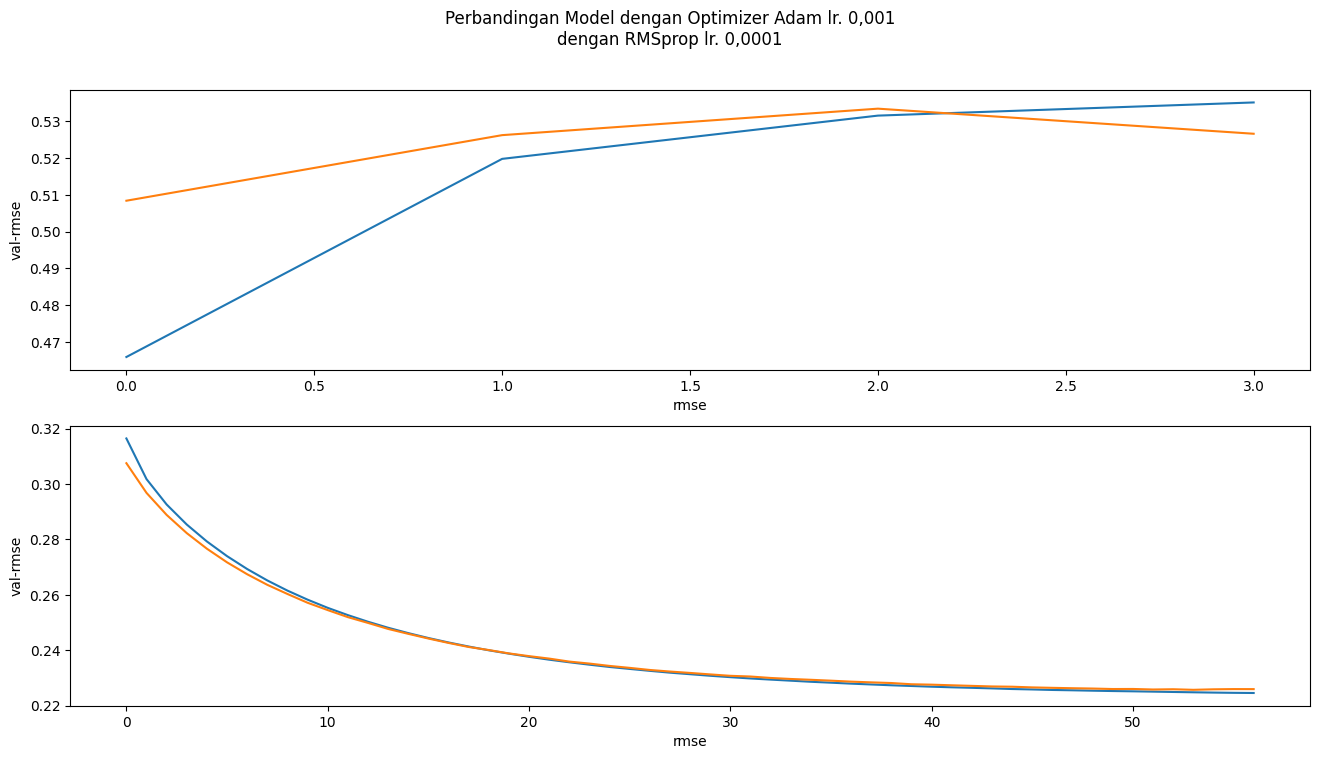

In [ ]:
fig, ax = plt.subplots(2, figsize=(16, 8))

mt1 = history_v1_1.history['root_mean_squared_error']
mv1 = history_v1_1.history['val_root_mean_squared_error']
mt2 = history_v1_2.history['root_mean_squared_error']
mv2 = history_v1_2.history['val_root_mean_squared_error']

ax[0].plot(mt1)
ax[0].plot(mv1)

ax[1].plot(mt2)
ax[1].plot(mv2)

for plot in ax.flat:
    plot.set(xlabel='rmse', ylabel='val-rmse')

plt.suptitle("Perbandingan Model dengan Optimizer Adam lr. 0,001\ndengan RMSprop lr. 0,0001")

plt.show()

### Load Weight

In [ ]:
def get_recommended_user(markdown=False):
    user_id = anime_list_df.user_id.sample(1).iloc[0]
    ## Ambil anime yang pernah di tonton user
    watched_anime = anime_list_df[anime_list_df.user_id == user_id]

    ## Ambil data anime yang belum pernah di tonton
    # Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
    anime_not_watched = anime_df[~anime_df['MAL_ID'].isin(watched_anime.anime_id.values)]['MAL_ID']
    anime_not_watched = list(
        set(anime_not_watched)
        .intersection(set(anime_to_anime_encoded.keys()))
    )

    ## Ambil Encoded Anime dari list anime yang belum pernah ditonton
    anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
    ## Ambil user encoded untuk user yang akan diberikan rekomendasi
    user_encoder = user_to_user_encoded.get(user_id)
    ## Set Data prediction berdasarkan encode user sekarang dengan encode anime yang belum pernah ditonton
    user_anime_array = np.hstack(
        ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
    )

    ## Prediksi rating
    model_v1_2.load_weights('/notebooks/model_1_2/cp.ckpt')
    ratings = model_v1_2.predict(user_anime_array).flatten()

    ## Ambil hasil dengan rating tertinggi
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    ## Ambil id anime berdasarkan hasil prediksi
    recommended_anime_ids = [
        anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
    ]

    ## Sort 10 Anime terbaik yang pernah user rating
    top_anime_user = (
        watched_anime.sort_values(
            by = 'rating',
            ascending=False
        )
        .head(10)
        .anime_id.values
    )

    anime_df_rows = anime_df[anime_df['MAL_ID'].isin(top_anime_user)]
    ## Tampilkan anime hasil prediksi dengan rating tertinggi
    recommended_anime = anime_df[anime_df['MAL_ID'].isin(recommended_anime_ids)]

    print('Showing recommendations for users: {}'.format(user_id))
    if(not markdown):
        print('===' * 9)
        print('Anime with high ratings from user')
        print('----' * 8)

        for row in anime_df_rows.itertuples():
            print(row.Name, ':', row.Genres)

        print('----' * 8)
        print('Top 10 Anime recommendation')
        print('----' * 8)


        for row in recommended_anime.itertuples():
            print(row.Name, ':', row.Genres)
    else:
        print("Top 10 Animes\n")
        print(anime_df_rows[anime_columns].to_markdown())
        print("Top 10 Animes Recommend\n")
        print(recommended_anime[anime_columns].to_markdown())


In [ ]:
anime_columns = ['MAL_ID', 'Name', 'Score', 'Genres', 'Type']

### Predict

In [ ]:
get_recommended_user()

# [anime_list_df.user_id == 104129]

531/531 [==============================] - 1s 2ms/step
Showing recommendations for users: 104937
Anime with high ratings from user
--------------------------------
One Piece Movie 1 : Action, Adventure, Comedy, Super Power, Fantasy, Shounen
One Piece Movie 9: Episode of Chopper Plus - Fuyu ni Saku, Kiseki no Sakura : Action, Adventure, Comedy, Super Power, Fantasy, Shounen
One Piece Film: Strong World : Action, Adventure, Comedy, Drama, Fantasy, Shounen
One Piece Film: Strong World Episode 0 : Action, Adventure, Comedy, Fantasy, Shounen, Super Power
One Piece 3D: Gekisou! Trap Coaster : Action, Adventure, Fantasy, Comedy, Shounen
One Piece Film: Z : Action, Adventure, Comedy, Drama, Fantasy, Shounen
Chuunibyou demo Koi ga Shitai! Ren : Comedy, Drama, Romance, School, Slice of Life
One Piece 3D2Y: Ace no shi wo Koete! Luffy Nakama Tono Chikai : Adventure, Comedy, Fantasy, Shounen
Re:Zero kara Hajimeru Isekai Seikatsu : Psychological, Drama, Thriller, Fantasy
One Piece Film: Gold : Actio

In [ ]:
get_recommended_user(True)

511/511 [==============================] - 1s 2ms/step
Showing recommendations for users: 256400
Top 10 Animes

|      |   MAL_ID | Name                                |   Score | Genres                                                                       | Type   |
|-----:|---------:|:------------------------------------|--------:|:-----------------------------------------------------------------------------|:-------|
|  142 |      164 | Mononoke Hime                       |    8.72 | Action, Adventure, Fantasy                                                   | Movie  |
|  428 |      457 | Mushishi                            |    8.69 | Adventure, Slice of Life, Mystery, Historical, Supernatural, Fantasy, Seinen | TV     |
| 1388 |     1530 | Kanon (2006)                        |    8.01 | Slice of Life, Supernatural, Drama, Romance                                  | TV     |
| 2061 |     2251 | Baccano!                            |    8.42 | Action, Comedy, Historical, Mystery, Sup

In [ ]:
!zip 'model.zip' '/notebooks/model_1_2' -r

updating: notebooks/model_1_2/ (stored 0%)
updating: notebooks/model_1_2/cp.ckpt.data-00000-of-00001 (deflated 5%)
updating: notebooks/model_1_2/checkpoint (deflated 38%)
updating: notebooks/model_1_2/cp.ckpt.index (deflated 58%)
